In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import os
import sys
import seaborn as sns
import re
from pathlib import Path
import json
from Bio import SeqIO
import scipy.stats as stat
from scipy.stats import linregress
import textwrap
import glob

sys.path.append("/home/ach94/scripts/")
sys.path.append("/home/ach94/projects/p13_iterative_optimization/e240_super_r1")

from neo2_util import *

In [ ]:
def find_named_parent(path: Path, parent_name: str):
    path = path.resolve()
    # Check if the current path itself matches
    if path.name == parent_name:
        return path

    for parent in path.parents:
        if parent.name == parent_name:
            return parent

    return None


working_directory_path = Path("/home/ach94/git/cleo")
working_directory_path = Path(os.path.abspath(""))
cleo_directory_path = find_named_parent(working_directory_path, "cleo")

if cleo_directory_path:
    sys.path.append(cleo_directory_path)
else:
    print("No cleo directory found.")

PosixPath('/home/ach94/git/cleo')

In [59]:
### setup the working directory
dirs_list = [
    "raw_data",
    "mappings",
    "processed_data",
    "graphs",
    "graphs/per_plate",
    "graphs/aggregated",
]

working_directory_path = Path(os.path.abspath(""))
directories = {}
directories["working"] = working_directory_path
for directory in dirs_list:
    directories[directory] = directories["working"] / directory
    directories[directory].mkdir(exist_ok=True)

In [60]:
# put in itopt
# json
# copy all the data to the raw_data folder
# find /net/expdata/Users/Baker_Lab/_itopt/neo2/data -type f -newermt 2024-11-14 -exec cp {} /home/ach94/projects/p13_iterative_optimization/e221_super_data/raw_data \;

In [61]:
# heatmap of rates for each dna plate

# test different mscarlett thresholds
# 4mu max isnt applied to the controls currently

In [77]:
# standard_curve_path = "/projects/ml/itopt/neo2_standards/241001_standard_curves_2.json"
# "/projects/ml/itopt/neo2_standards/241202_standard_curves_jake_mod.json"
standard_curve_path = (
    "/projects/ml/itopt/neo2_standards/241202_standard_curves_jake_mod.json"
)


mscarlett_threshold = 0.025  # uM mscarlett in enzyme reaction
cv_threshold = 1  #
rate_stdev_from_background = 3  # rate

fit_interval = (0, 900)

In [78]:
# Get all files in the directories["working"] directory
raw_data_files = glob.glob(str(directories["raw_data"] / "*.txt"))
mappings_data_files = glob.glob(str(directories["mappings"] / "*"))

print(f"found {len(raw_data_files)} raw data files")
print(f"found {len(mappings_data_files)} mapping files")

mappings_df_list = []
mscarlett_df_list = []
kinetics_df_list = []

for file in mappings_data_files:
    ## Import well mappings
    df_mappings = pd.read_csv(file)
    df_mappings = clean_mappings_df(df_mappings)
    mappings_df_list.append(df_mappings)

df_mappings = pd.concat(mappings_df_list)

##############################
##############################
# correct mappings files
df_temp = df_mappings[
    (df_mappings.replicate_number == 1) & (df_mappings.sample_type == "sample")
]
duplicates = df_temp[df_temp.name.duplicated()].reset_index(drop=True).name.tolist()
print(f"found {len(duplicates)} duplicates in the mappings files")

# samples = df_mappings[df_mappings.sample_type == "sample"].name.unique()

duplicate_name_pairs = []
duplicate_names = []

for duplicate_name in duplicates:
    source_wells = df_mappings.loc[df_mappings.name == duplicate_name][
        "source_dna_well"
    ].unique()
    number_of_duplicates = len(source_wells)

    for i in range(0, number_of_duplicates):  # -1
        source_well_to_change = df_mappings.loc[df_mappings.name == duplicate_name][
            "source_dna_well"
        ].unique()[i]

        new_duplicate_name = duplicate_name + f":duplicate{i}"
        duplicate_name_pairs.append((duplicate_name, new_duplicate_name))
        duplicate_names.append(duplicate_name)
        duplicate_names.append(duplicate_name)
        duplicate_name_pairs.append((duplicate_name, duplicate_name))
        duplicate_names.append(new_duplicate_name)

        df_mappings.loc[
            (df_mappings.name == duplicate_name)
            & (df_mappings.source_dna_well == source_well_to_change),
            "name",
        ] = new_duplicate_name

df_temp = df_mappings[
    (df_mappings.replicate_number == 1) & (df_mappings.sample_type == "sample")
]
print(
    f"there are {len(df_temp[df_temp.name.duplicated()].reset_index(drop=True).name.tolist())} duplicates that weren't renamed"
)
##############################
##############################

for file in raw_data_files:
    ## Import mscarlett and merge with mappings
    df_mscarlett = parse_neo2_endpoint(file, start_row=54, parse_name=True)
    mscarlett_df_list.append(df_mscarlett)

    ## Import kinetics and merge with mappings
    df_kinetics = parse_neo2_kinetics(file, start_row=58, parse_name=True)
    kinetics_df_list.append(df_kinetics)

## Combine all dataframes
df_mscarlett = pd.concat(mscarlett_df_list)
df_kinetics = pd.concat(kinetics_df_list)

## Merge with mappings
df_mscarlett = df_mscarlett.merge(
    df_mappings, on=["well", "sample_number", "plate_number"], how="left"
)
df_kinetics = df_kinetics.merge(
    df_mappings, on=["well", "sample_number", "plate_number"], how="left"
)

found 6 raw data files
found 6 mapping files
found 2 duplicates in the mappings files
there are 2 duplicates that weren't renamed


In [79]:
df_mappings[df_mappings.name.isin(duplicates)]

,replicate_number,well,sample_type,row,column,source_dna_well,sequence,name,sample_number,plate_number


In [80]:
print(
    f"found mappings for {len(df_mappings[["sample_number", "plate_number"]].drop_duplicates())} total plates from {len(df_mappings.sample_number.unique())} samples"
)
print(
    f"found mscarlett for {len(df_mscarlett[["sample_number", "plate_number"]].drop_duplicates())} total plates from {len(df_mscarlett.sample_number.unique())} samples"
)
print(
    f"found kinetics for {len(df_kinetics[["sample_number", "plate_number"]].drop_duplicates())} total plates from {len(df_kinetics.sample_number.unique())} samples"
)

found mappings for 6 total plates from 2 samples
found mscarlett for 6 total plates from 2 samples
found kinetics for 6 total plates from 2 samples


In [81]:
# check that all the plates have serial numbers
print(f"identified mscarlett serial numbers: {df_mscarlett["serial_number"].unique()}")
print(f"identified kinetics serial numbers: {df_kinetics["serial_number"].unique()}")

# # correct the serial_number if absent for some reason...
# df_mscarlett.loc[df_mscarlett["serial_number"] == "Unknown", "serial_number"] = (
#     "21060423"
# )
# df_kinetics.loc[df_kinetics["serial_number"] == "Unknown", "serial_number"] = "21060423"

['21060423']
['21060423']


In [82]:
## inputs: data_path, mappings_path, standard_curve_path, directories
# sample_number, plate_number = get_sample_plate_info(data_path)

## Apply standard curves
df_mscarlett = apply_mscarlett_standard_curve(
    df_mscarlett,
    standard_curve_path,
    epsilon=1e-8,
    write_path=None,
)
df_mscarlett.to_csv(directories["processed_data"] / f"1_mscarlett.csv")

df_kinetics = apply_4MU_standard_curve(
    df_kinetics,
    standard_curve_path,
    epsilon=1e-8,
    write_path=None,
)
df_kinetics.to_csv(directories["processed_data"] / f"2_kinetics.csv")

## calculate max 4MU
df_4MU_max = calculate_max_4MU(df_kinetics)

## fit line to 4MU data to determine rate
df_kinetics_fits = apply_tidy_kinetic_fit(
    df_kinetics,
    fit_function=fit_line,
    time_column="time",
    y_column="4MU_um",
    time_range=fit_interval,
    group_columns=[
        "well",
        "replicate_number",
        "sample_number",
        "name",
        "sample_type",
        "plate_number",
    ],
    clean=True,
)

## subract background rate
df_kinetics_fits = apply_tidy_background_subtraction(
    df_kinetics_fits,
    value="rate",
    grouping=["sample_number", "plate_number"],
    epsilon=1e-8,
)

## normalize by mscarlett
df_kinetics_fits = normalize_rate_by_mscarlett(df_kinetics_fits, df_mscarlett)
df_kinetics.to_csv(directories["processed_data"] / f"3_kinetics_fits.csv")

## calculate aggregated mscalett stats
df_mscarlett_stats = calculate_mscarlett_stats(df_mscarlett, epsilon=1e-8)
df_kinetics_stats = calculate_kinetics_stats(df_kinetics_fits, df_4MU_max, epsilon=1e-8)

## generate fitted data for plotting
df_kinetics_fitted = generate_kinetic_fit_data(df_kinetics, df_kinetics_fits)
df_kinetics_fitted.to_csv(directories["processed_data"] / f"4_kinetics_fitted.csv")

## apply filters
## mscarlett threshold applied to each replicate individually and all three must pass
## cv threshold applied to cv
## background stdev threshold applied to each replicate individually and all three must pass
df_stats = apply_filters(
    df_kinetics_fits,
    df_kinetics_stats,
    df_mscarlett_stats,
    mscarlett_threshold=mscarlett_threshold,
    cv_threshold=cv_threshold,
    stdev_from_background=rate_stdev_from_background,
)

df_export = build_complete_df(
    df_mappings, df_mscarlett, df_4MU_max, df_kinetics_fits, df_stats
)
df_export.to_csv(directories["processed_data"] / f"5_complete_df.csv")

In [83]:
df_export

,name,sequence,source_dna_well,sample_number,plate_number,sample_type,well_1,well_2,well_3,source_file,...,mscarlett_threshold_pass,rate_norm_mean,rate_norm_std_dev,rate_norm_cv,rate_mean,rate_std_dev,rate_cv,4MU_um_max_mean,rate_norm_cv_threshold_pass,rate_norm_threshold_pass
0,frag1_parent_1:frag2_temp0.2num009:frag3_temp0...,SENEKLVEKVLEATRRIAREEAVKYKDAFLRAYRARDGAGLRRVIT...,A17,2,3,sample,A1,A9,A17,/home/ach94/projects/p13_iterative_optimizatio...,...,True,0.030703,0.017185,0.559697,0.001391,0.000859,0.617977,2.840382,True,True
1,frag1_temp0.2num032:frag2_temp0.5num115COMBO:f...,TEDEVRVQRVLDATREIARREAVAYKDAFLEAYRARDGAGLRRVLT...,B17,2,3,sample,B1,B9,B17,/home/ach94/projects/p13_iterative_optimizatio...,...,False,9681.286894,8765.228046,0.905378,0.000097,0.000088,0.905378,1.592790,True,False
2,frag1_temp0.5num114COMBO:frag2_temp0.2num022CO...,SDEQKRVDAVLKATREIAKQVAKDYKDAFLAAFDARDGAALRRVIT...,C17,2,3,sample,C1,C9,C17,/home/ach94/projects/p13_iterative_optimizatio...,...,False,58.599533,101.469735,1.731579,0.000090,0.000085,0.945500,1.620310,False,False
3,frag1_temp0.2num054:frag2_temp0.2num009:frag3_...,SEDDKLVEKVLNATREIARQHAVGYRDDFLAAWRARDGAGLRRVIT...,D17,2,3,sample,D1,D9,D17,/home/ach94/projects/p13_iterative_optimizatio...,...,True,0.009361,0.001157,0.123569,0.000355,0.000073,0.205285,1.855762,True,True
4,frag1_temp0.5num090:frag2_temp0.2num040COMBO:f...,SPEDARVARVLAATREIARREAEGFREDFLRAYAARDGAALRRVIT...,E17,2,3,sample,E1,E9,E17,/home/ach94/projects/p13_iterative_optimizatio...,...,True,0.004433,0.002347,0.529457,0.000226,0.000112,0.497167,1.739565,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,frag1_temp0.2num054:frag2_parent_2:frag3_temp0...,SEDDKLVEKVLNATREIARQHAVGYRDDFLAAWRARDGAGLRRVIT...,L8,1,1,sample,L8,L16,L24,/home/ach94/projects/p13_iterative_optimizatio...,...,False,8881.387442,6272.343775,0.706235,0.000089,0.000063,0.706235,1.623368,True,False
764,frag1_temp0.5num093COMBO:frag2_temp0.5num115CO...,SADEERVAAVLKATTEIAREVAEDYSAAFDKAFNARDGAGLRRVLT...,M8,1,1,sample,M8,M16,M24,/home/ach94/projects/p13_iterative_optimizatio...,...,True,0.000999,0.000729,0.729311,0.000089,0.000066,0.746194,1.577501,True,False
765,frag1_temp0.2num091COMBO:frag2_temp0.5num115CO...,SEEDERVAKVLEATRRIAREVAEGYKADFLKAYNAQDGAGLRRVLT...,O8,1,1,sample,O8,O16,O24,/home/ach94/projects/p13_iterative_optimizatio...,...,False,0.001053,0.001206,1.145215,0.000018,0.000022,1.256130,1.458245,False,False
766,frag1_temp0.2num091COMBO:frag2_temp0.5num115CO...,SEEDERVAKVLEATRRIAREVAEGYKADFLKAYNAQDGAGLRRVLT...,N8,1,1,sample,N8,N16,N24,/home/ach94/projects/p13_iterative_optimizatio...,...,False,0.003138,0.003288,1.047890,0.000041,0.000043,1.048003,1.519402,False,False


In [84]:
print(f"starting with {len(df_export)} samples")
print(
    f"samples that pass the mscarlett filter: {len(df_export[df_export["mscarlett_threshold_pass"] == True])}"
)
print(
    f"samples that pass the rate filter: {len(df_export[df_export["rate_norm_threshold_pass"] == True])}"
)
print(
    f"samples that pass the cv filter: {len(df_export[df_export["rate_norm_cv_threshold_pass"] == True])}"
)

df_pass = df_export[df_export["mscarlett_threshold_pass"] == True]
df_pass = df_pass[df_pass["rate_norm_cv_threshold_pass"] == True]
print(f"samples that pass mscarlett and cv filter: {len(df_pass)}")

df_pass = df_export[df_export["mscarlett_threshold_pass"] == True]
df_pass = df_pass[df_pass["rate_norm_threshold_pass"] == True]
df_pass = df_pass[df_pass["rate_norm_cv_threshold_pass"] == True]
print(f"samples that pass mscarlett, rate, and cv filter: {len(df_pass)}")

starting with 768 samples
samples that pass the mscarlett filter: 383
samples that pass the rate filter: 173
samples that pass the cv filter: 543
samples that pass mscarlett and cv filter: 278
samples that pass mscarlett, rate, and cv filter: 124


In [85]:
df = df_kinetics_fits

# Get unique pairs of plate_number and sample_number
unique_pairs = df[["sample_number", "plate_number"]].drop_duplicates()

# Optionally, convert to a list of tuples if needed
unique_pairs_list = list(unique_pairs.itertuples(index=False, name=None))

print(unique_pairs_list)

[(1, 3), (1, 2), (1, 1), (2, 3), (2, 2), (2, 1)]


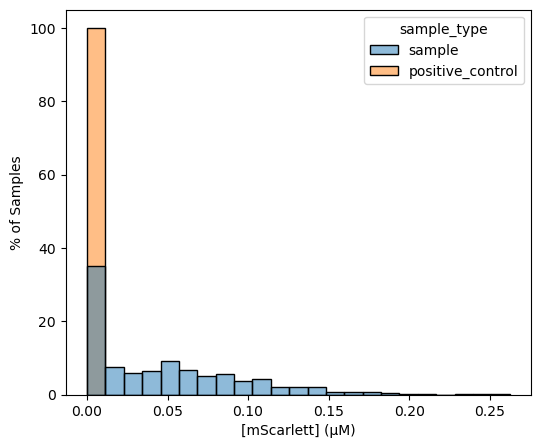

In [86]:
df_plot = df_mscarlett
title = f""
figure_name = f"mscarlett_distibution"
figure_directory = directories["graphs/aggregated"]
write_figure = True
write_format = "png"


# filter for samples where all three replicates pass the mscarlett threshold
df_plot = df_plot[df_plot["sample_type"].isin(["sample", "positive_control"])]

fig, axes = plt.subplots(1, 1, figsize=(6, 5))

sns.histplot(
    data=df_plot,
    x="mscarlett_um",
    hue="sample_type",
    multiple="layer",
    kde=False,
    stat="percent",  # Normalize to density
    common_norm=False,  # Normalize each hue group independently
    ax=axes,
)
plt.xlabel("[mScarlett] (μM)")
plt.ylabel("% of Samples")
plt.show()

if write_figure:
    figure_path = figure_directory / f"{figure_name}.{write_format}"
    fig.savefig(figure_path, format=write_format)

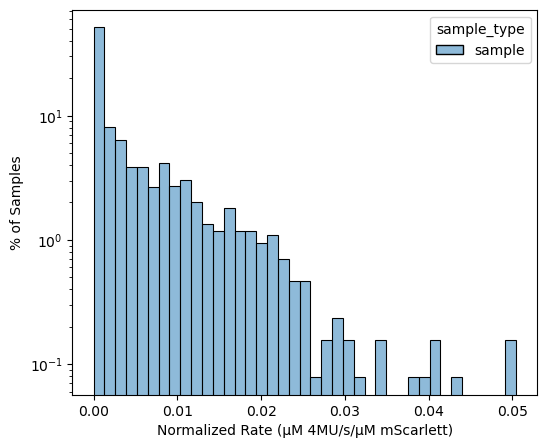

In [87]:
df_plot = df_kinetics_fits
title = f""
figure_name = f"rate_norm_distibution"
figure_directory = directories["graphs/aggregated"]
write_figure = True
write_format = "png"

# filter for samples where all three replicates pass the mscarlett threshold
df_plot = df_plot[df_plot["mscarlett_um"] > mscarlett_threshold]
df_plot = df_plot[df_plot["sample_type"].isin(["sample", "positive_control"])]

fig, axes = plt.subplots(1, 1, figsize=(6, 5))


sns.histplot(
    data=df_plot,
    x="rate_minus_background_normalized",
    hue="sample_type",
    multiple="layer",
    kde=False,
    stat="percent",  # Normalize to density
    common_norm=False,  # Normalize each hue group independently
    ax=axes,
)
plt.xlabel("Normalized Rate (\u03BCM 4MU/s/\u03BCM mScarlett)")
plt.ylabel("% of Samples")
plt.yscale("log")
plt.show()

if write_figure:
    figure_path = figure_directory / f"{figure_name}.{write_format}"
    fig.savefig(figure_path, format=write_format)

/tmp/ipykernel_1061469/797785083.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["sample_plate"] = (
/tmp/ipykernel_1061469/797785083.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
/tmp/ipykernel_1061469/797785083.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


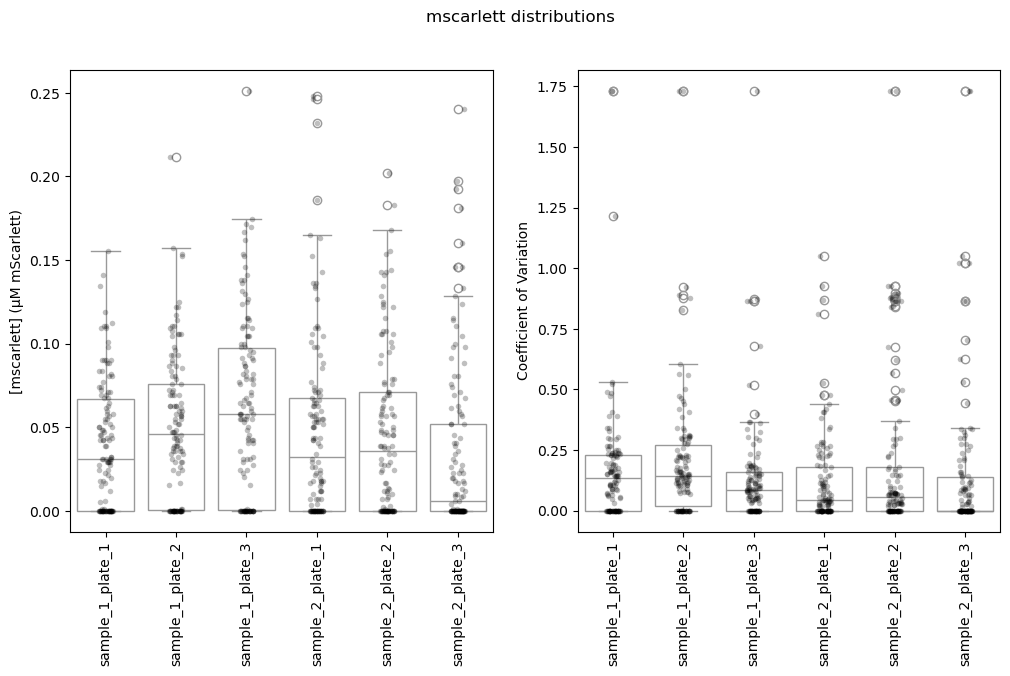

In [88]:
df_plot = df_export
value = "mscarlett"
title = f"mscarlett distributions"
figure_name = f"mscarlett_plate_distibutions"
figure_directory = directories["graphs/aggregated"]
write_figure = True
write_format = "png"

# df_plot = df_plot[df_plot["mscarlett_threshold_pass"] == True]
# df_plot = df_plot[df_plot["rate_norm_cv_threshold_pass"] == True]
df_plot = df_plot[df_plot["sample_type"].isin(["sample", "positive_control"])]

df_plot["sample_plate"] = (
    "sample_"
    + df_plot["sample_number"].astype(str)
    + "_plate_"
    + df_plot["plate_number"].astype(str)
)

df_plot = df_plot.sort_values(by=["sample_number", "plate_number"])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(
    data=df_plot, x="sample_plate", y=f"{value}_mean", color="white", ax=axes[0]
)
sns.stripplot(
    data=df_plot,
    x="sample_plate",
    y=f"{value}_mean",
    size=4,
    color="black",
    alpha=0.25,
    ax=axes[0],
)
axes[0].set_xlabel("")
axes[0].set_ylabel("[mscarlett] (\u03BCM mScarlett)")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

sns.boxplot(data=df_plot, x="sample_plate", y=f"{value}_cv", color="white", ax=axes[1])
sns.stripplot(  # stripplot
    data=df_plot,
    x="sample_plate",
    y=f"{value}_cv",
    size=4,
    color="black",
    alpha=0.25,
    ax=axes[1],
)
axes[1].set_xlabel("")
axes[1].set_ylabel("Coefficient of Variation")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)

fig.suptitle(f"mscarlett distributions")

plt.show()


if write_figure:
    figure_path = figure_directory / f"{figure_name}.{write_format}"
    fig.savefig(figure_path, format=write_format)

/tmp/ipykernel_1061469/67209492.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
/tmp/ipykernel_1061469/67209492.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


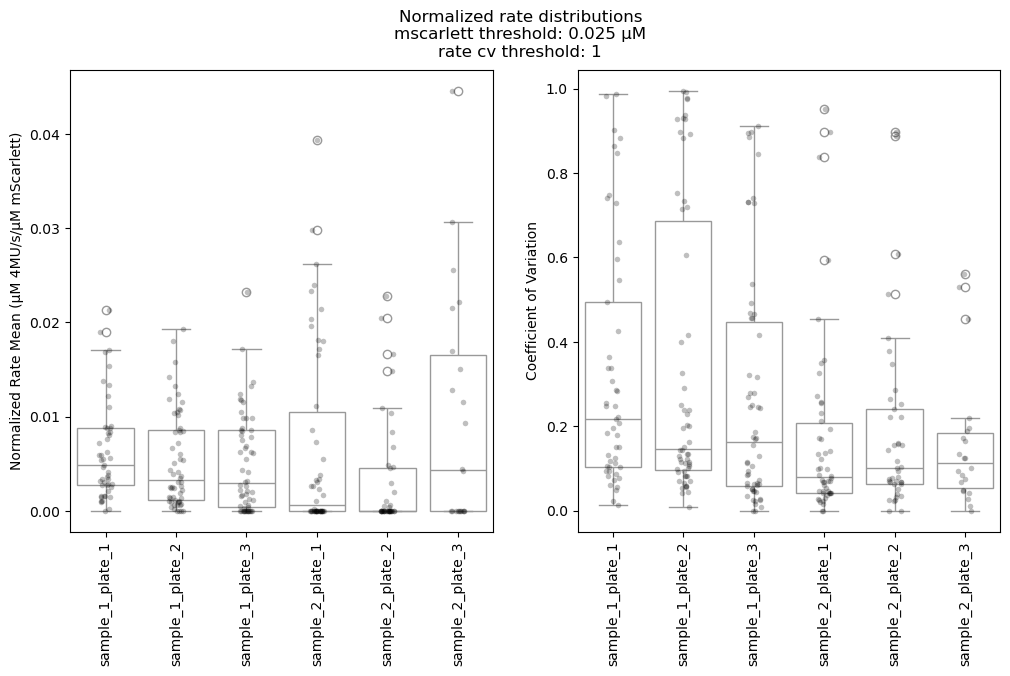

In [89]:
df_plot = df_export
value = "rate_norm"
title = f"Normalized rate distributions\nmscarlett threshold: {mscarlett_threshold} μM\nrate cv threshold: {cv_threshold}"
figure_name = f"rate_norm_plate_distibutions"
figure_directory = directories["graphs/aggregated"]
write_figure = True
write_format = "png"


df_plot = df_export
df_plot = df_plot[df_plot["mscarlett_threshold_pass"] == True]
df_plot = df_plot[df_plot["rate_norm_cv_threshold_pass"] == True]
df_plot = df_plot[df_plot["sample_type"].isin(["sample", "positive_control"])]

df_plot["sample_plate"] = (
    "sample_"
    + df_plot["sample_number"].astype(str)
    + "_plate_"
    + df_plot["plate_number"].astype(str)
)

df_plot = df_plot.sort_values(by=["sample_number", "plate_number"])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(
    data=df_plot, x="sample_plate", y=f"{value}_mean", color="white", ax=axes[0]
)
sns.stripplot(
    data=df_plot,
    x="sample_plate",
    y=f"{value}_mean",
    size=4,
    color="black",
    alpha=0.25,
    ax=axes[0],
)
axes[0].set_xlabel("")
axes[0].set_ylabel("Normalized Rate Mean (\u03BCM 4MU/s/\u03BCM mScarlett)")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

sns.boxplot(data=df_plot, x="sample_plate", y=f"{value}_cv", color="white", ax=axes[1])
sns.stripplot(
    data=df_plot,
    x="sample_plate",
    y=f"{value}_cv",
    size=4,
    color="black",
    alpha=0.25,
    ax=axes[1],
)
axes[1].set_xlabel("")
axes[1].set_ylabel("Coefficient of Variation")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)

fig.suptitle(title)

plt.show()

if write_figure:
    figure_path = figure_directory / f"{figure_name}.{write_format}"
    fig.savefig(figure_path, format=write_format)

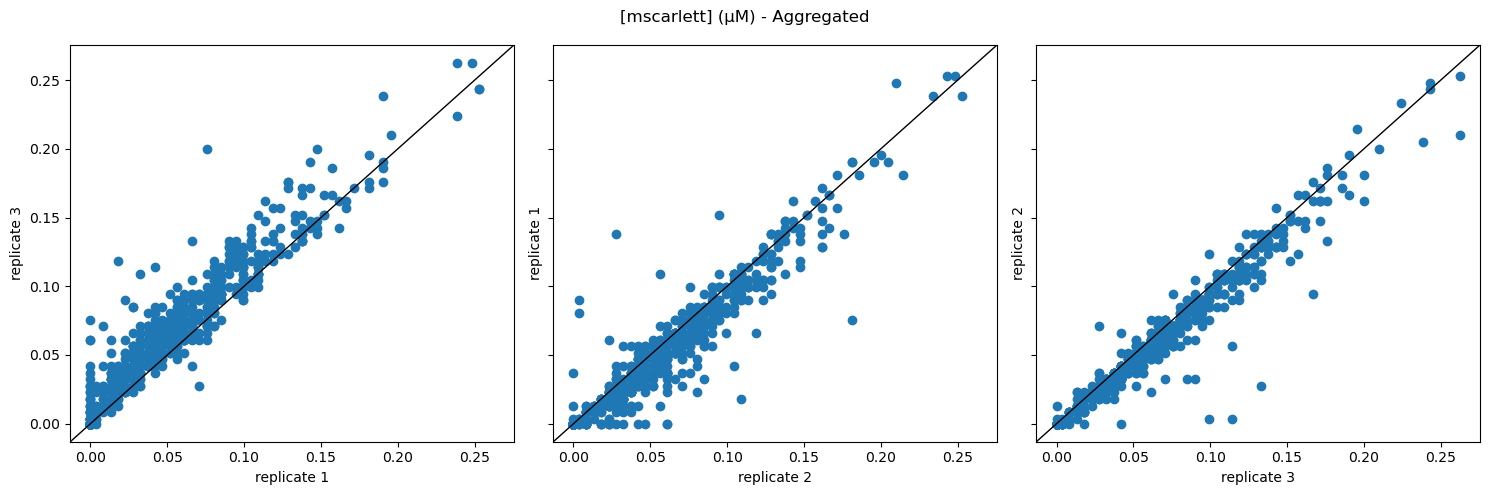

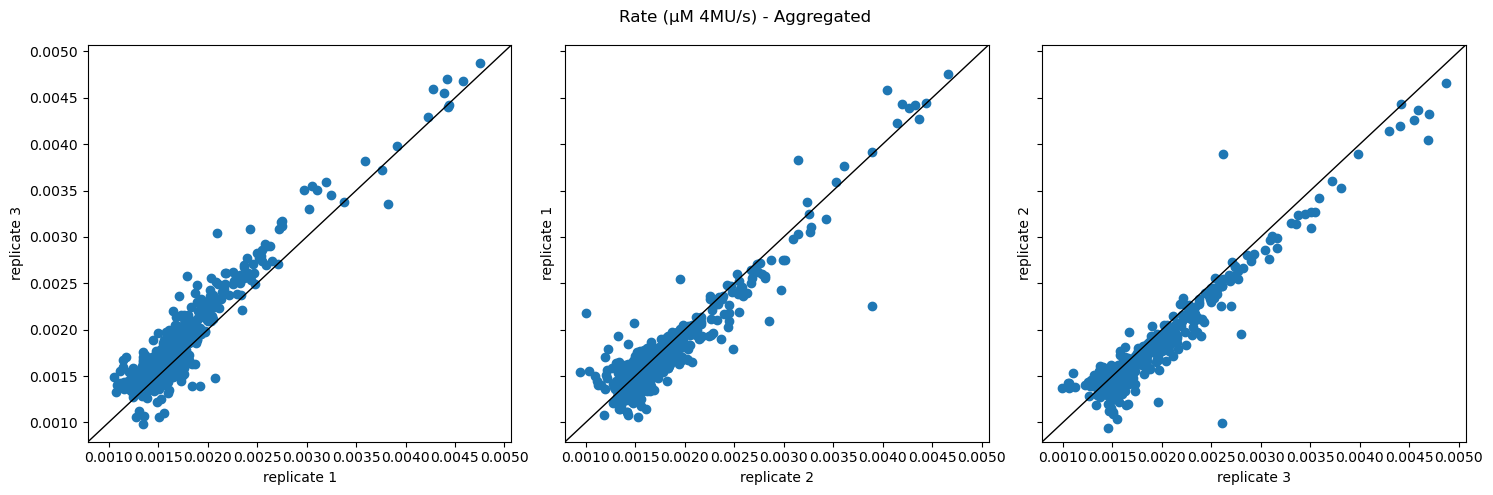

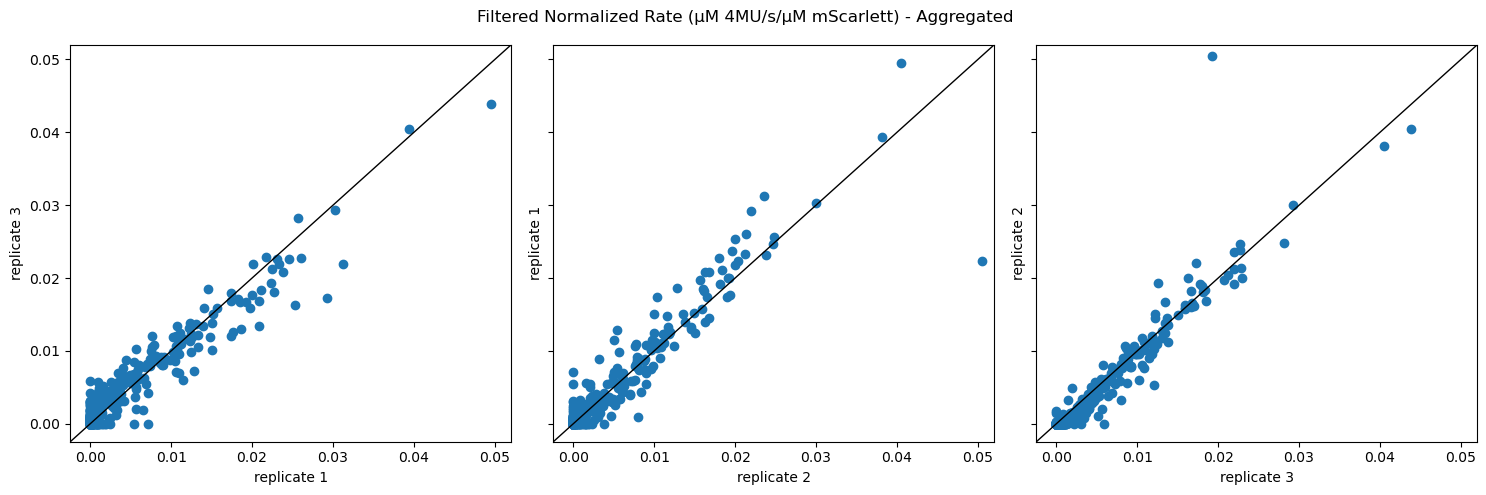

In [90]:
df_plot = df_mscarlett
value = "mscarlett_um"
replicates = [1, 2, 3]
title = f"[mscarlett] (\u03BCM) - Aggregated"
figure_name = f"mcarlett_parity_aggregated"
figure_directory = directories["graphs/aggregated"]
write_figure = True
write_format = "png"

fig, axs = parity_plot(
    df_plot,
    value,
    replicates,
    title,
    figure_name,
    figure_directory,
    write_figure,
    write_format,
)

df_plot = df_kinetics_fits
value = "rate"
replicates = [1, 2, 3]
title = f"Rate (\u03BCM 4MU/s) - Aggregated"
figure_name = f"rate_parity_aggregated"
figure_directory = directories["graphs/aggregated"]
write_figure = True
write_format = "png"

fig, axs = parity_plot(
    df_plot,
    value,
    replicates,
    title,
    figure_name,
    figure_directory,
    write_figure,
    write_format,
)

# filter for samples where all three replicates pass the mscarlett threshold
df_plot = df_kinetics_fits
df_filter = df_stats[df_stats.mscarlett_threshold_pass == True]
df_plot = df_plot[df_plot["name"].isin(df_filter.name)]
df_plot = df_plot[df_plot["sample_type"] == "sample"]

value = "rate_minus_background_normalized"
replicates = [1, 2, 3]
title = f"Filtered Normalized Rate (\u03BCM 4MU/s/\u03BCM mScarlett) - Aggregated"
figure_name = f"rate_norm_parity_aggregated"
figure_directory = directories["graphs/aggregated"]
write_figure = True
write_format = "png"

fig, axs = parity_plot(
    df_plot,
    value,
    replicates,
    title,
    figure_name,
    figure_directory,
    write_figure,
    write_format,
)

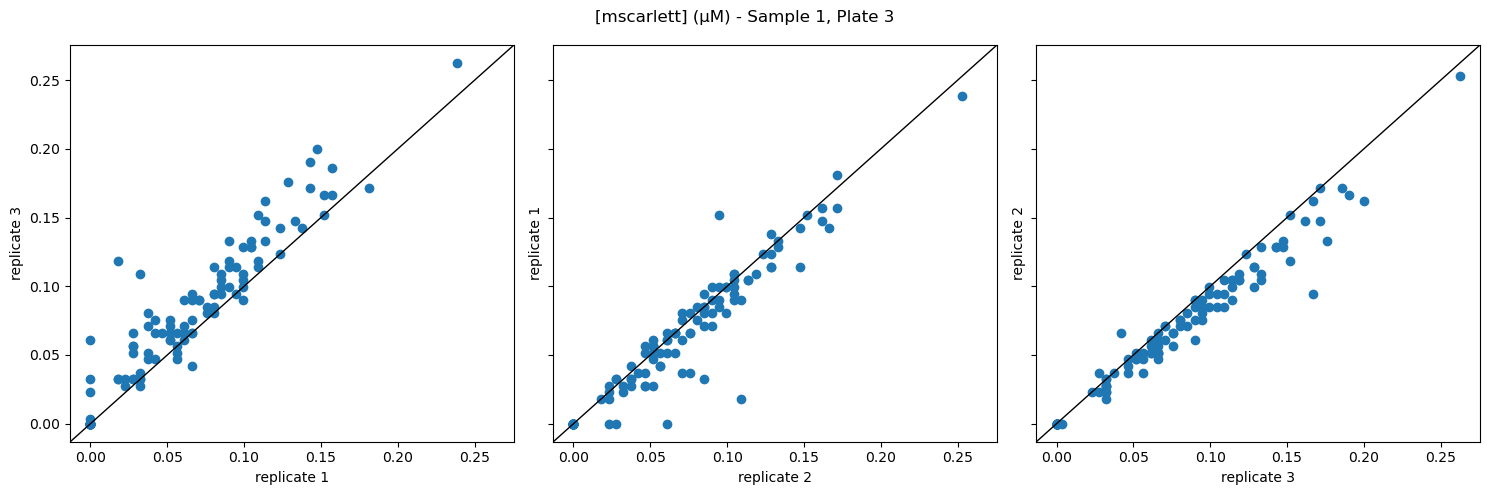

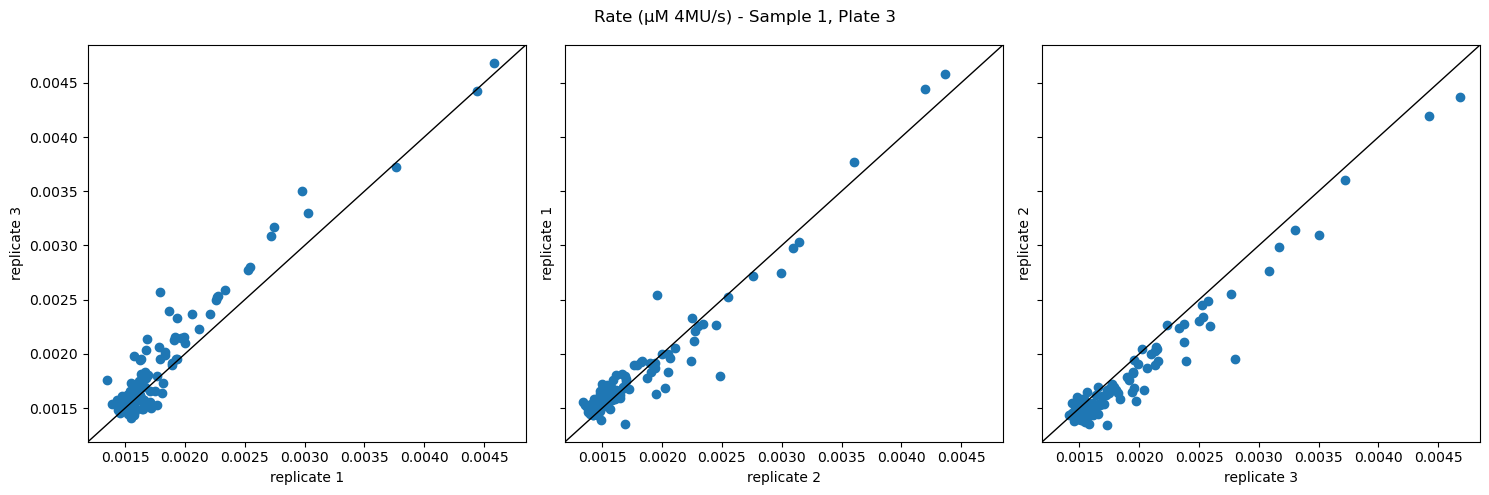

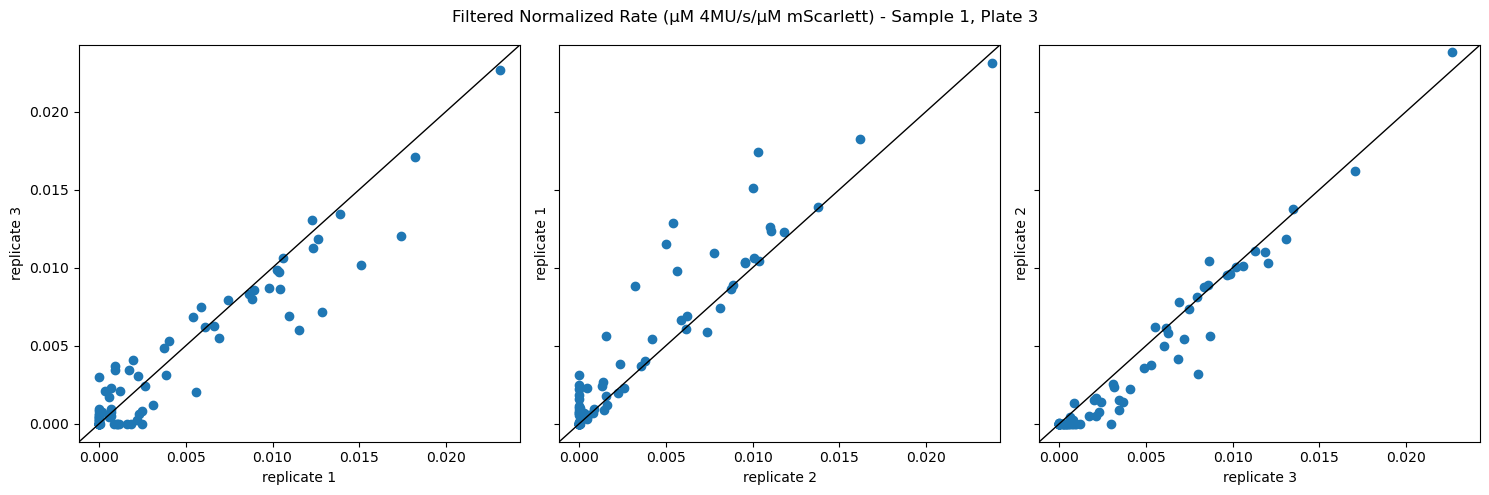

/home/ach94/projects/p13_iterative_optimization/e240_super_r1/neo2_util.py:1228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["row_num"] = df_plot["row"].map(row_map)


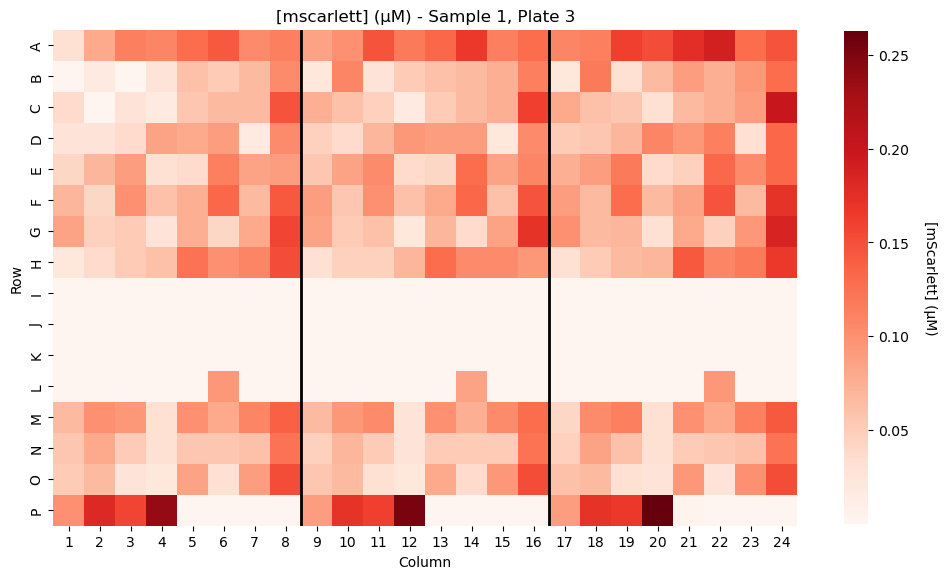

/home/ach94/projects/p13_iterative_optimization/e240_super_r1/neo2_util.py:1295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["Well_Row"] = df_plot["well"].str[0]  # A-P
/home/ach94/projects/p13_iterative_optimization/e240_super_r1/neo2_util.py:1296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["Well_Col"] = df_plot["well"].str[1:].astype(int)  # 1-24


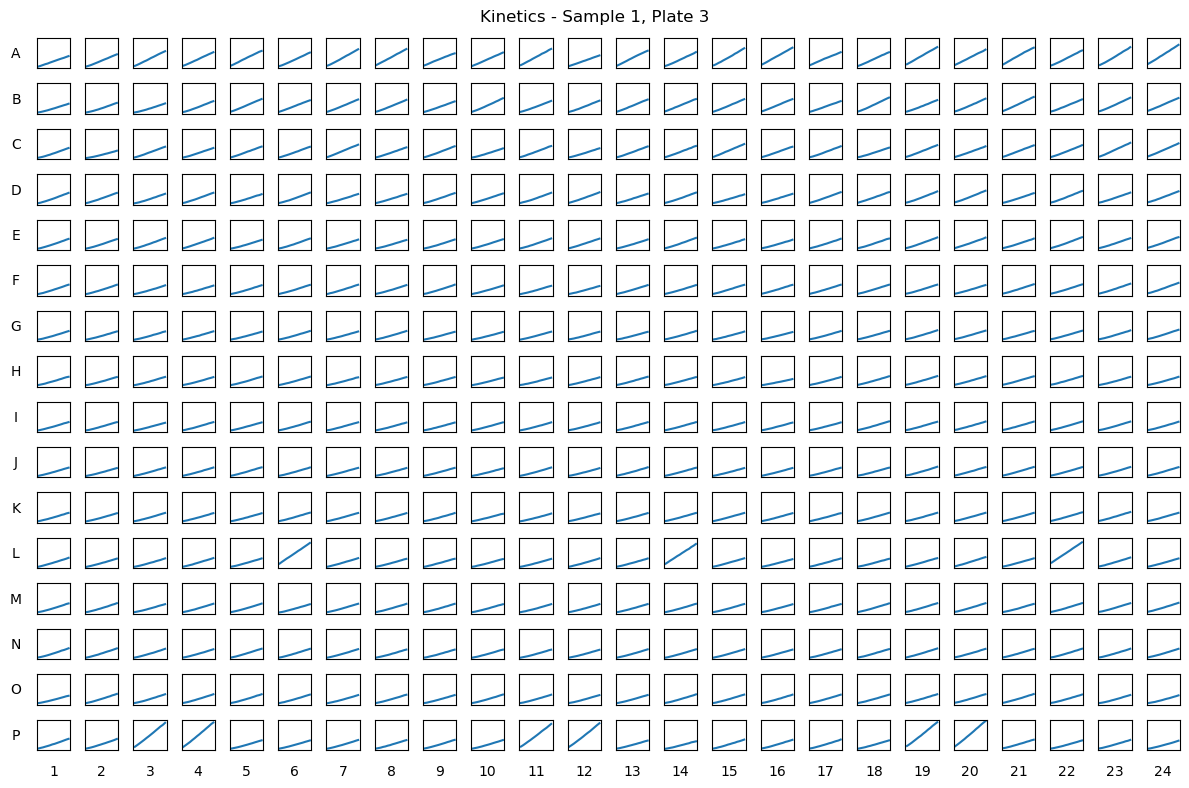

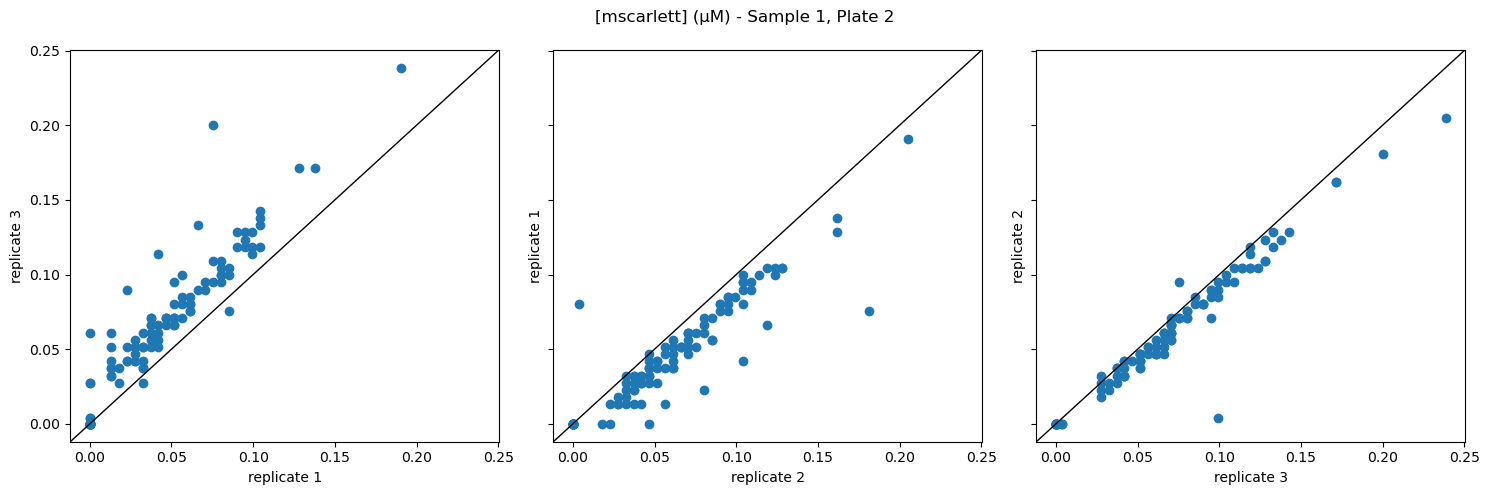

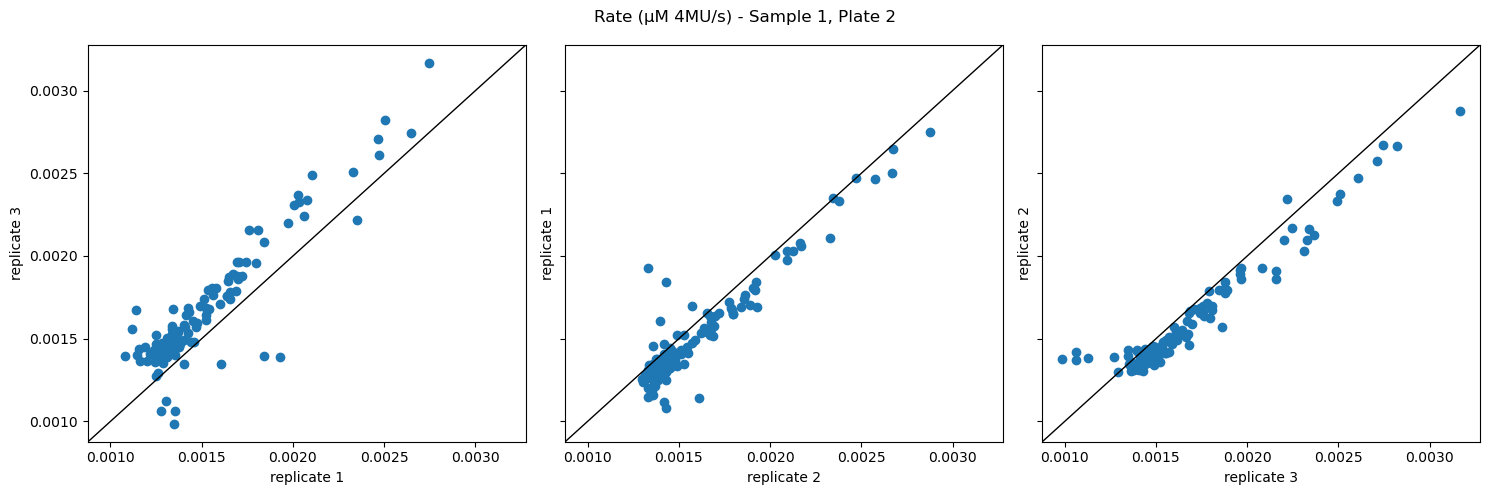

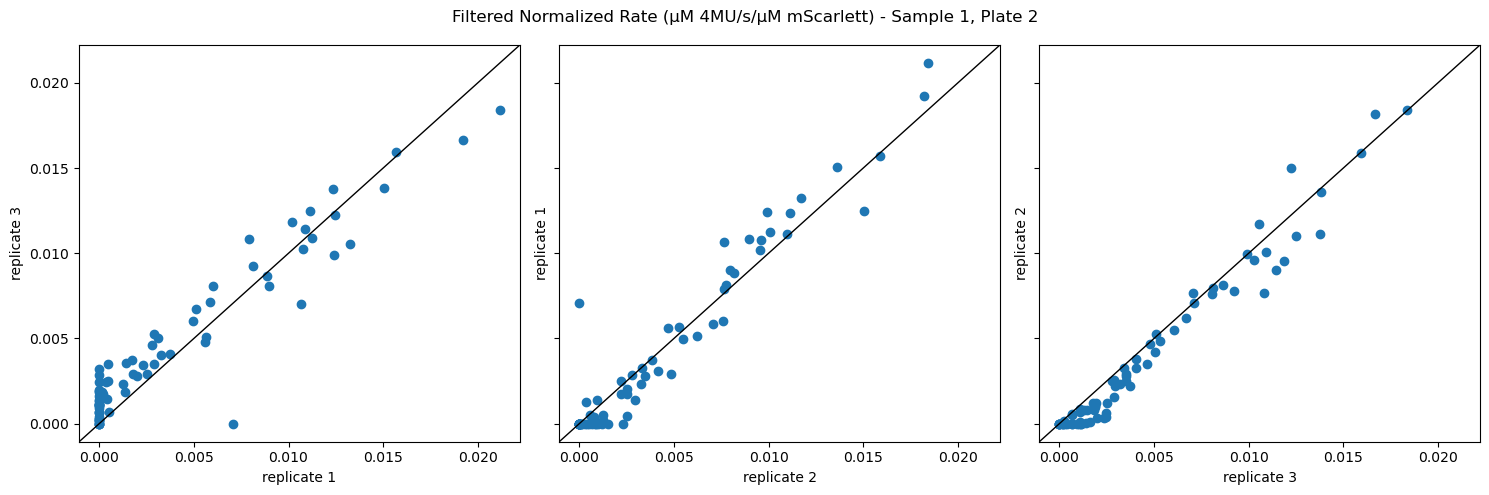

/home/ach94/projects/p13_iterative_optimization/e240_super_r1/neo2_util.py:1228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["row_num"] = df_plot["row"].map(row_map)


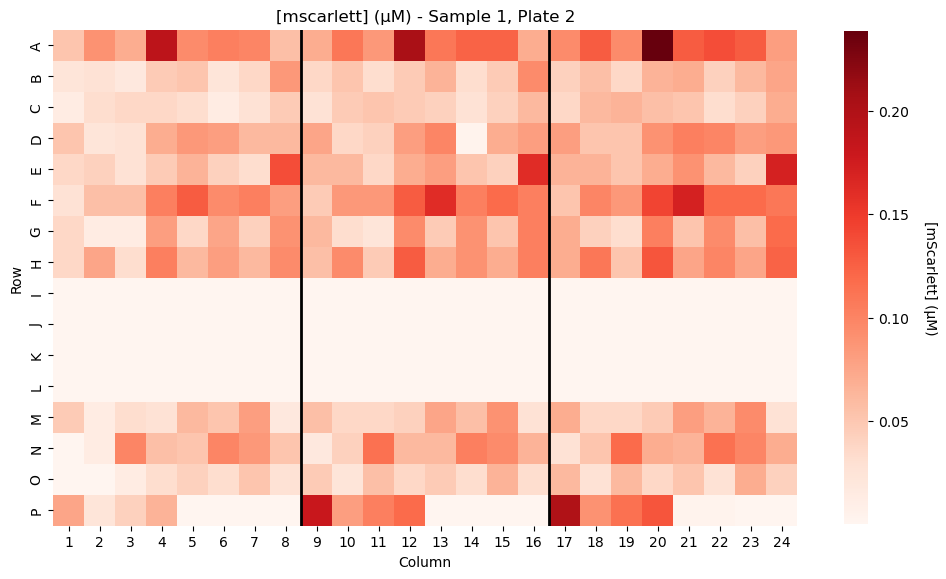

/home/ach94/projects/p13_iterative_optimization/e240_super_r1/neo2_util.py:1295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["Well_Row"] = df_plot["well"].str[0]  # A-P
/home/ach94/projects/p13_iterative_optimization/e240_super_r1/neo2_util.py:1296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["Well_Col"] = df_plot["well"].str[1:].astype(int)  # 1-24


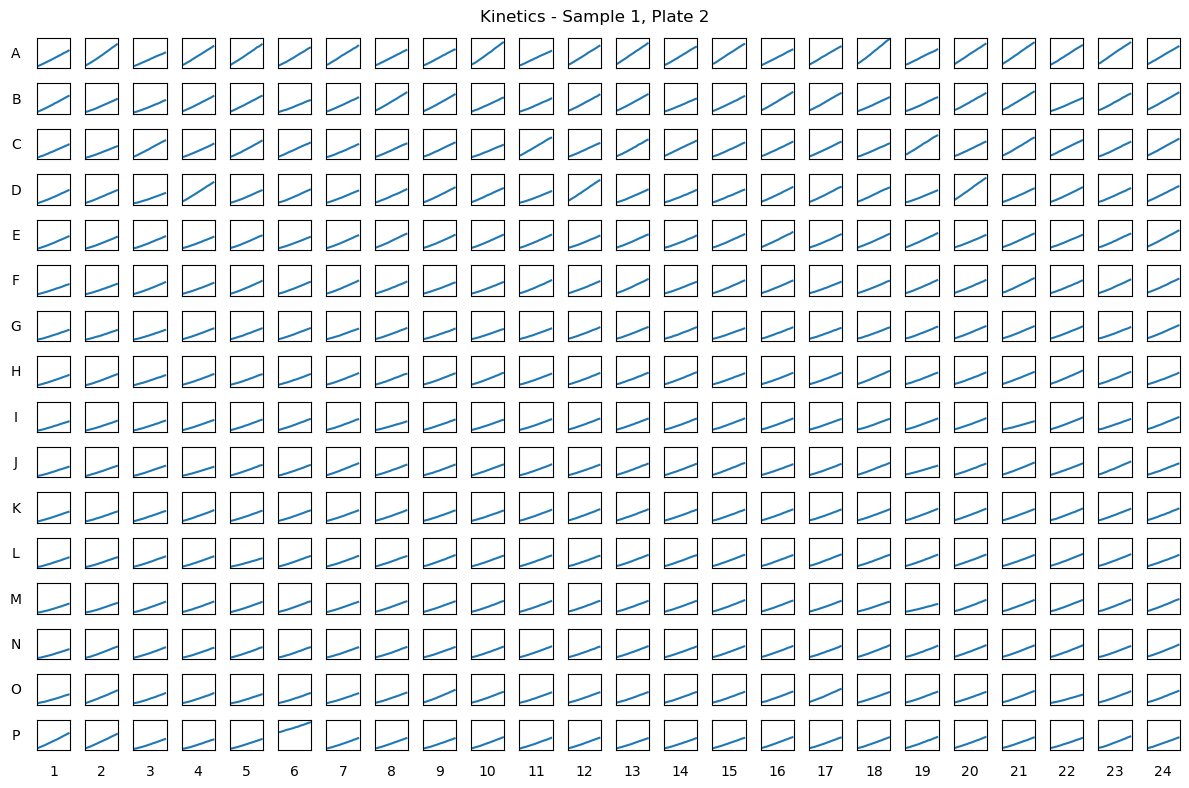

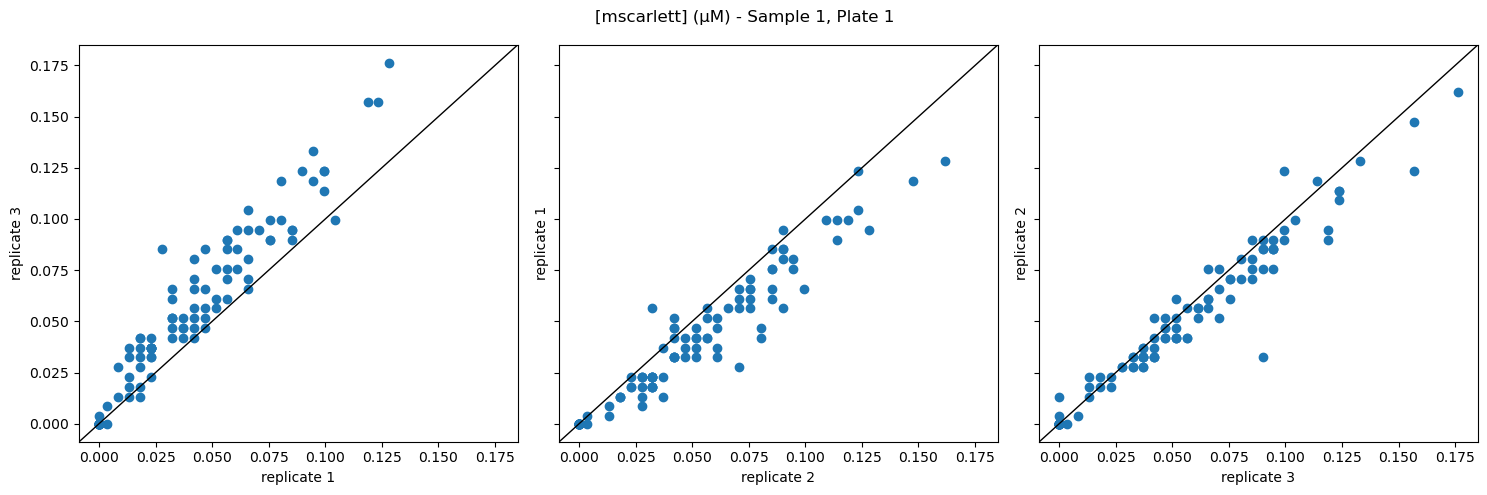

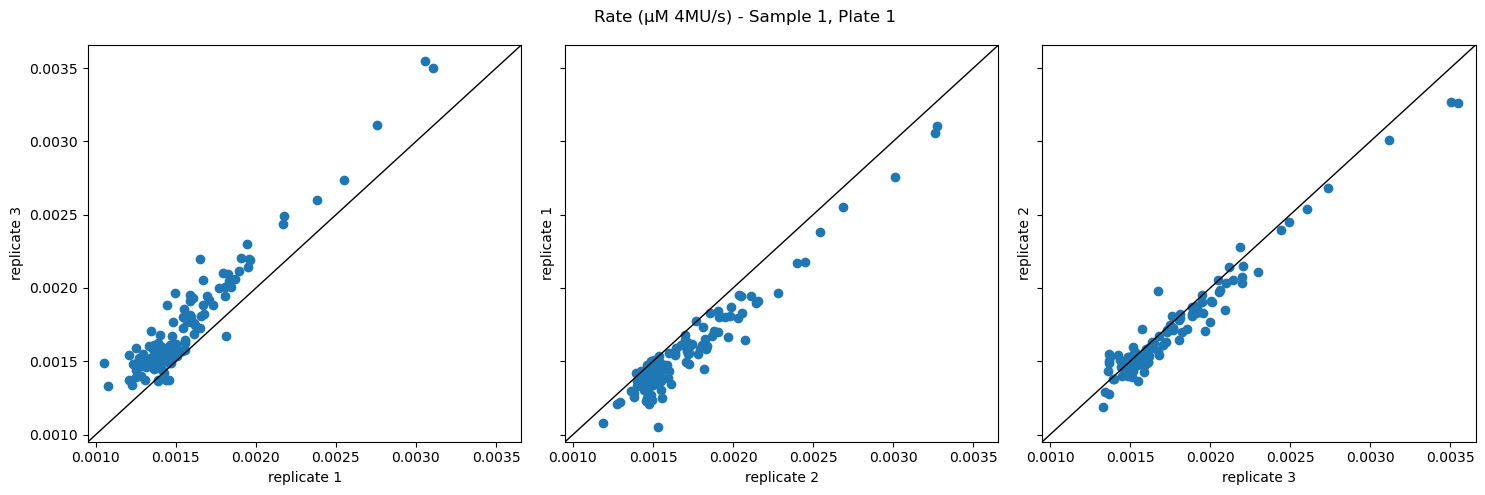

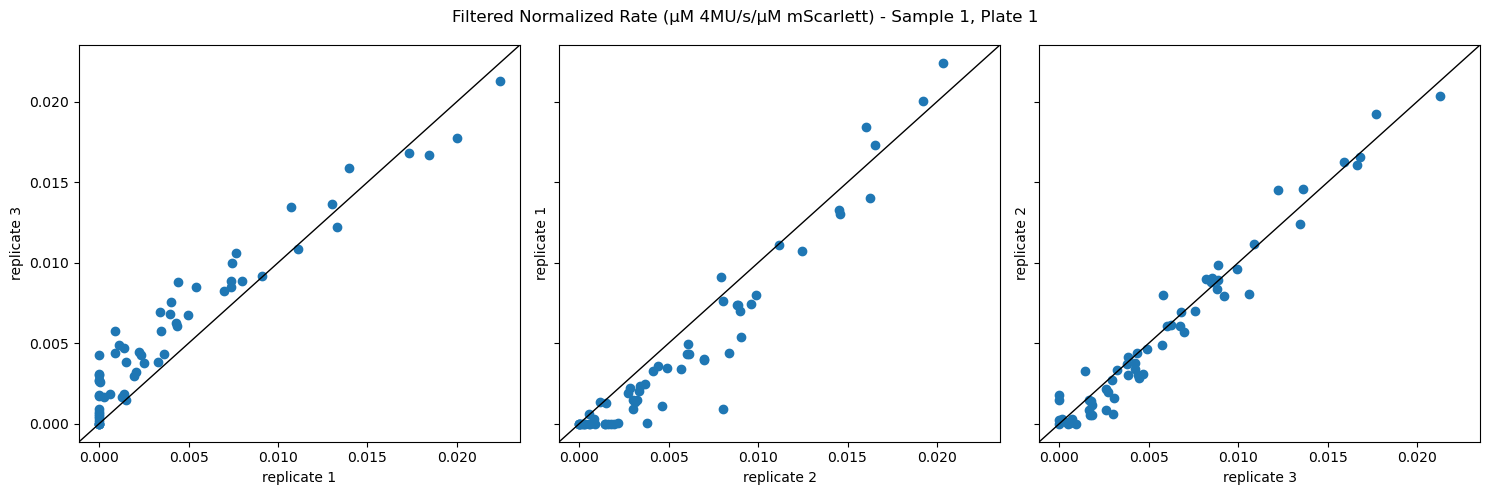

/home/ach94/projects/p13_iterative_optimization/e240_super_r1/neo2_util.py:1228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["row_num"] = df_plot["row"].map(row_map)


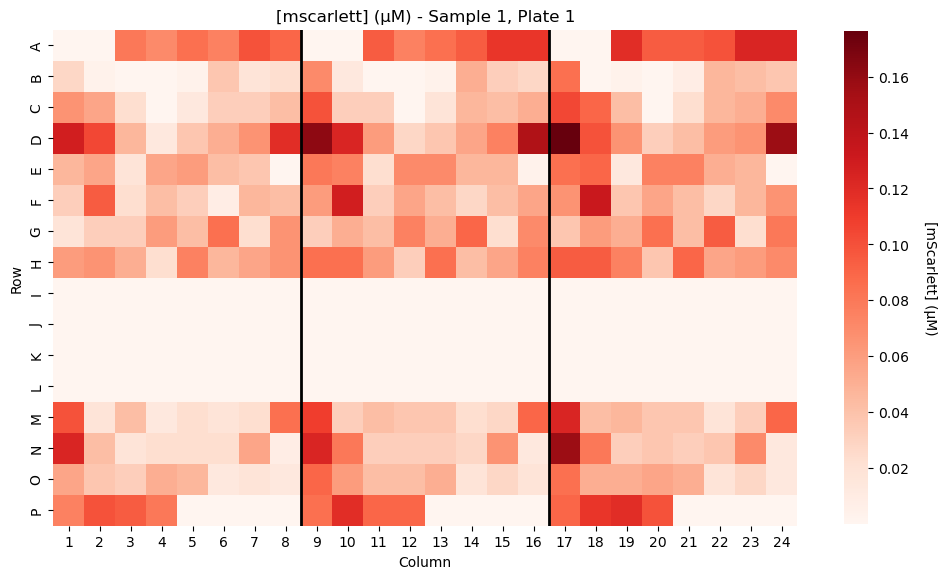

/home/ach94/projects/p13_iterative_optimization/e240_super_r1/neo2_util.py:1295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["Well_Row"] = df_plot["well"].str[0]  # A-P
/home/ach94/projects/p13_iterative_optimization/e240_super_r1/neo2_util.py:1296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["Well_Col"] = df_plot["well"].str[1:].astype(int)  # 1-24


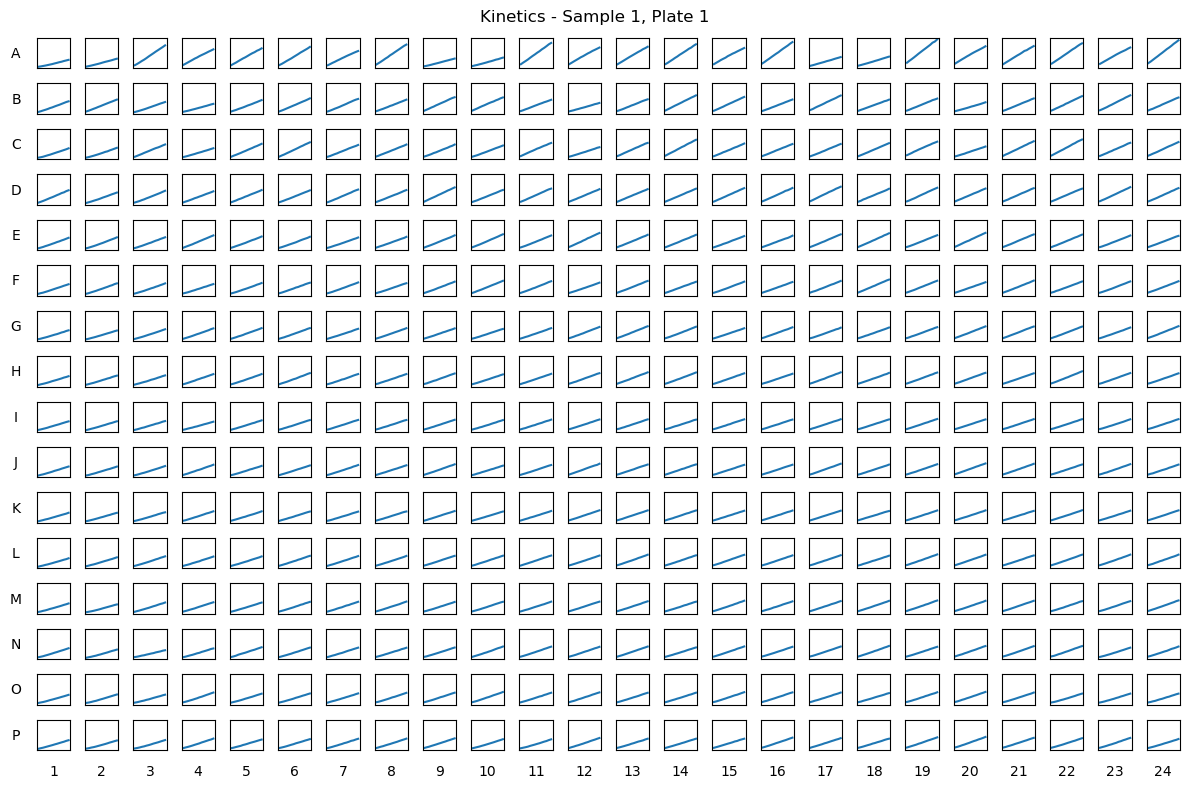

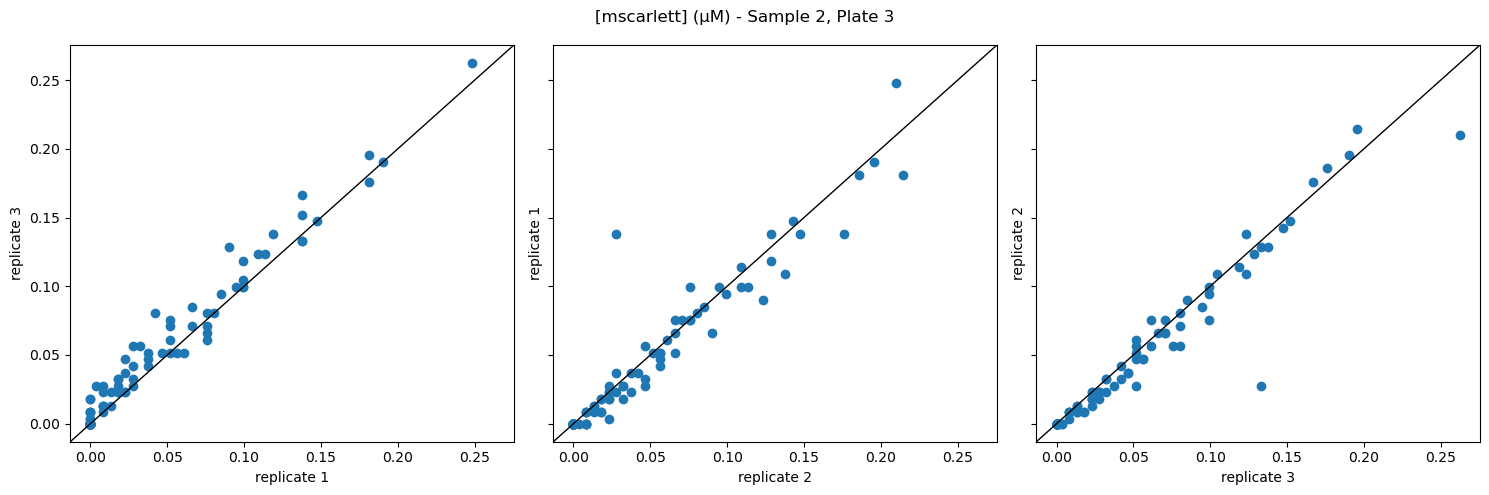

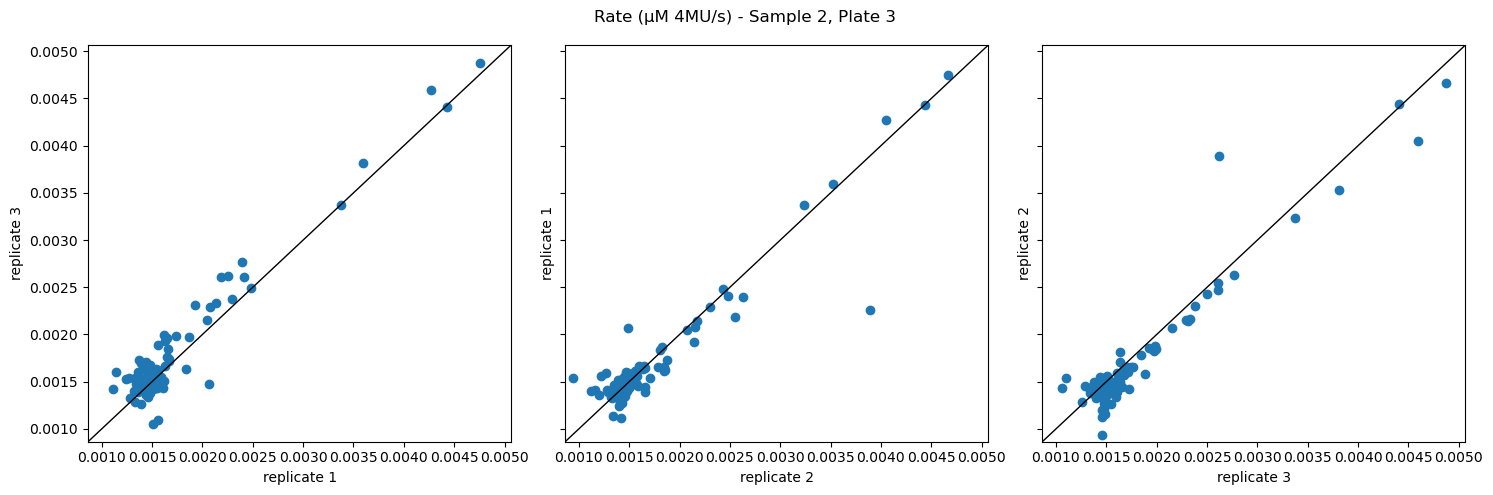

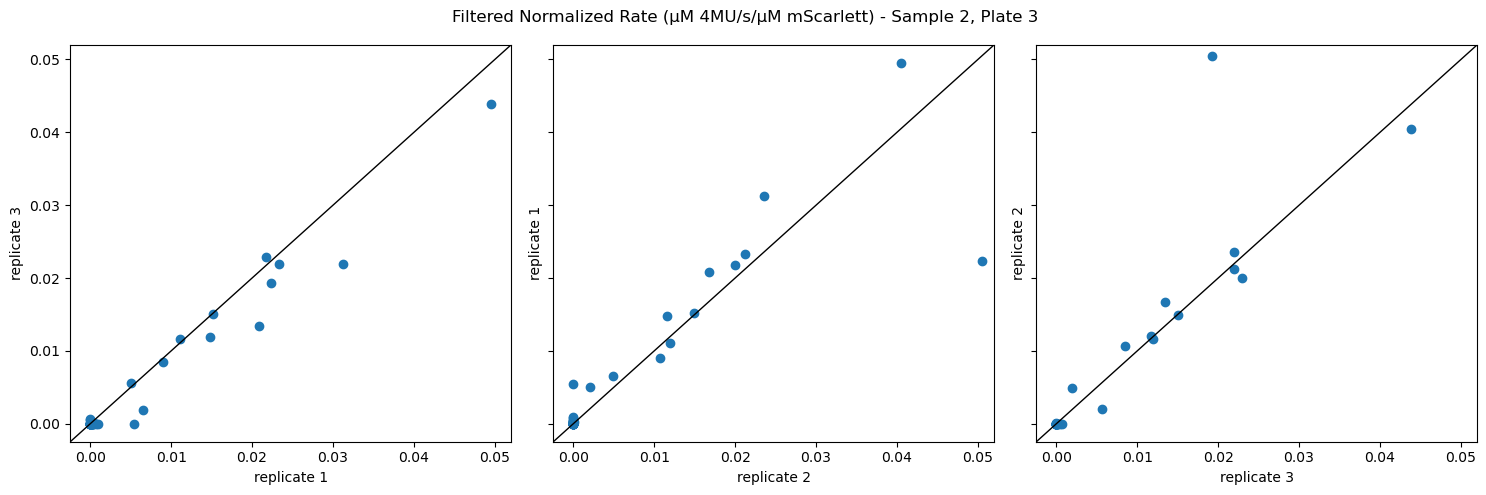

/home/ach94/projects/p13_iterative_optimization/e240_super_r1/neo2_util.py:1228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["row_num"] = df_plot["row"].map(row_map)


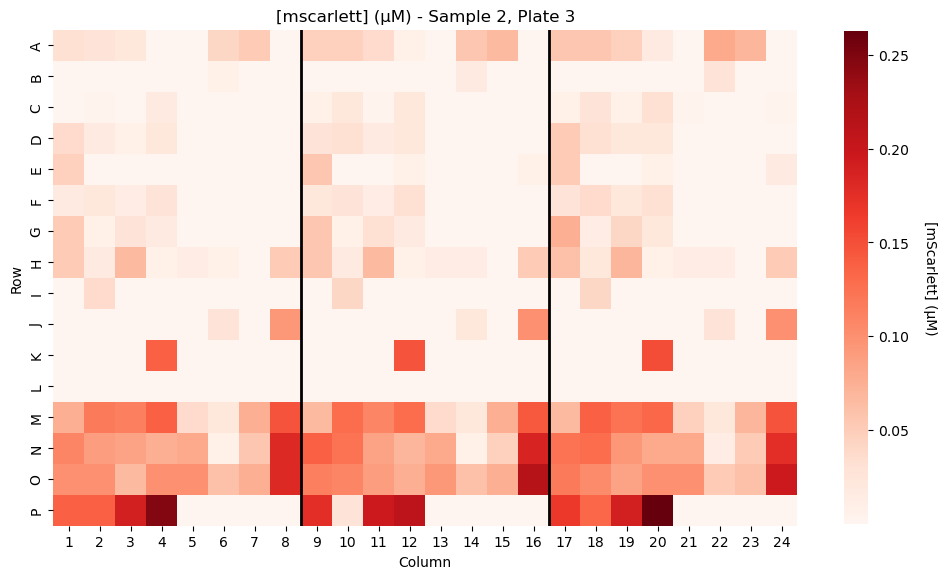

/home/ach94/projects/p13_iterative_optimization/e240_super_r1/neo2_util.py:1295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["Well_Row"] = df_plot["well"].str[0]  # A-P
/home/ach94/projects/p13_iterative_optimization/e240_super_r1/neo2_util.py:1296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["Well_Col"] = df_plot["well"].str[1:].astype(int)  # 1-24


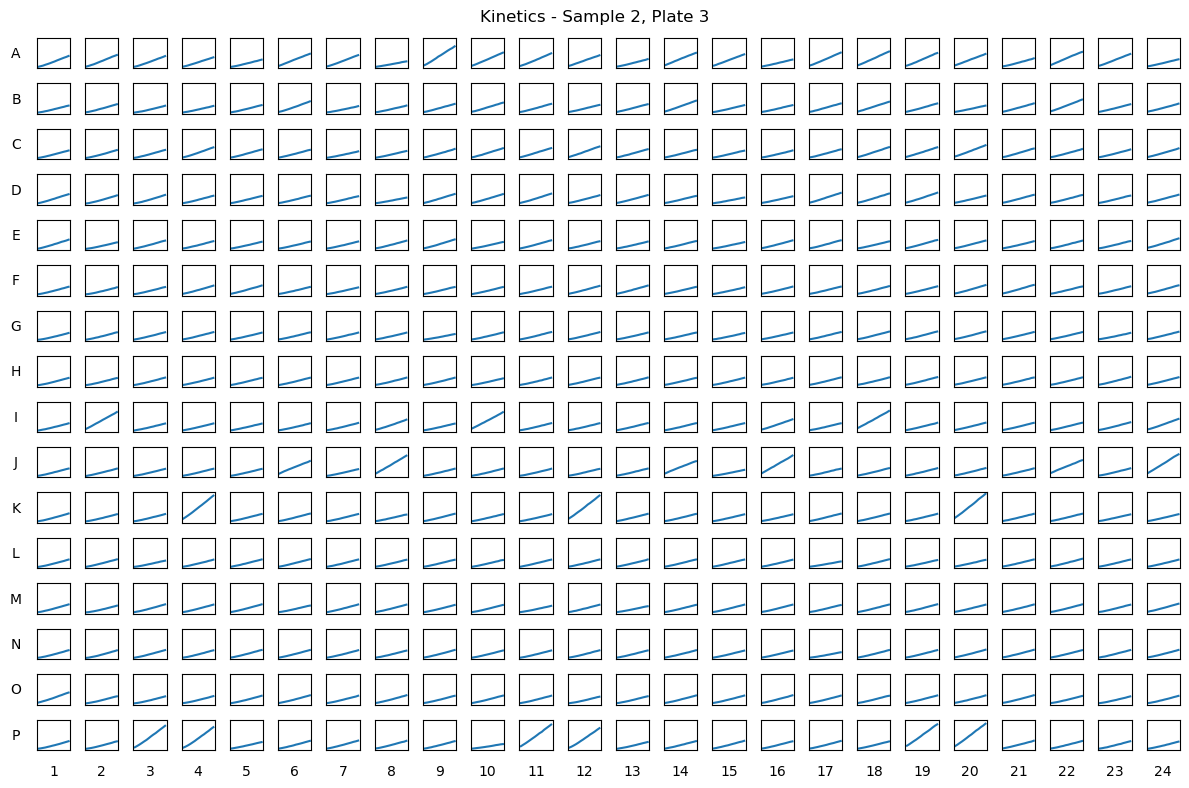

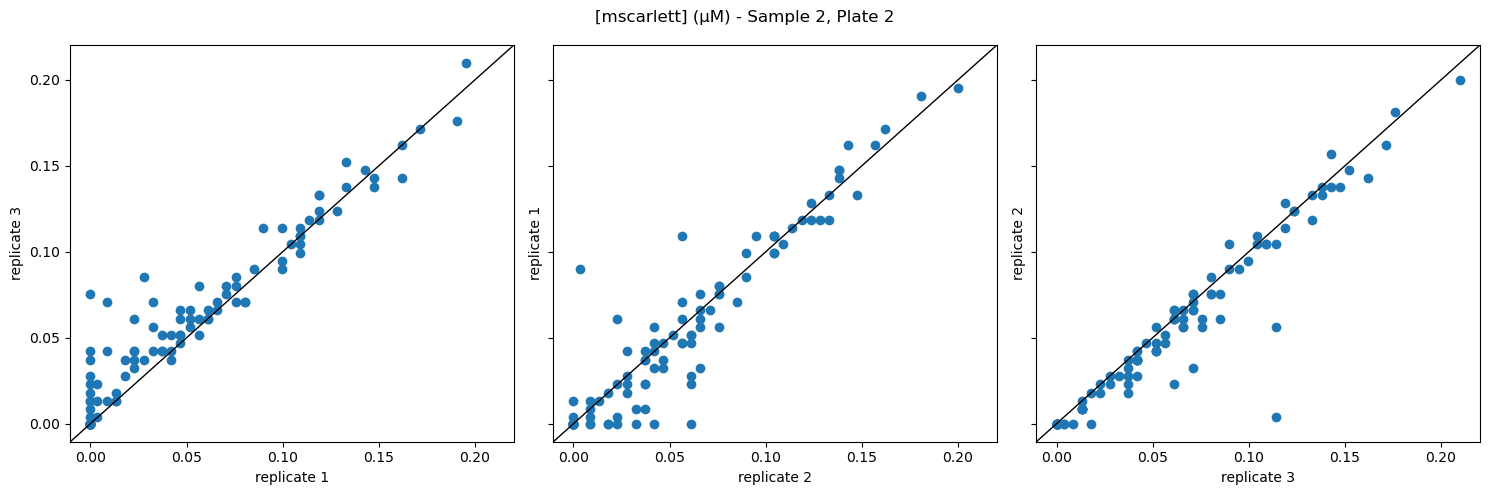

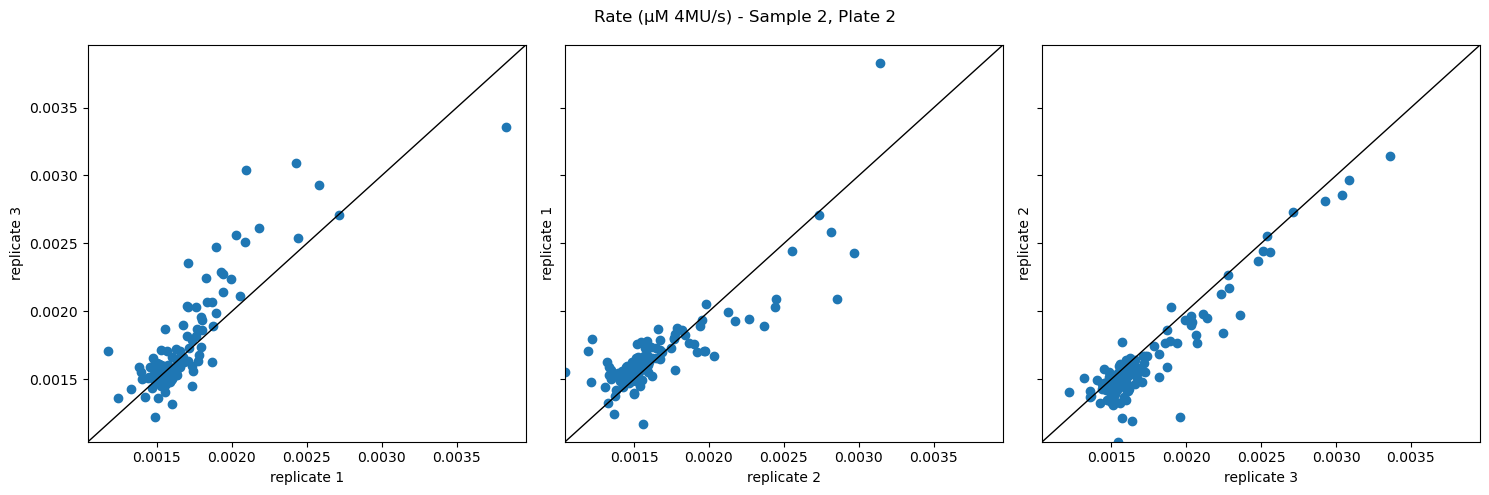

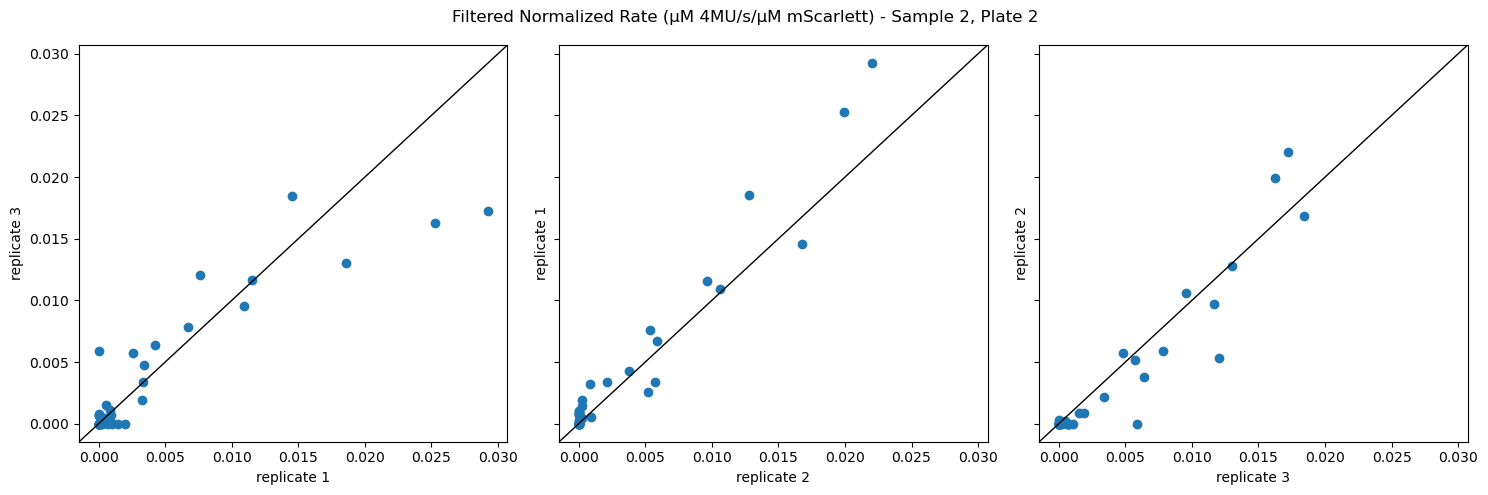

/home/ach94/projects/p13_iterative_optimization/e240_super_r1/neo2_util.py:1228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["row_num"] = df_plot["row"].map(row_map)


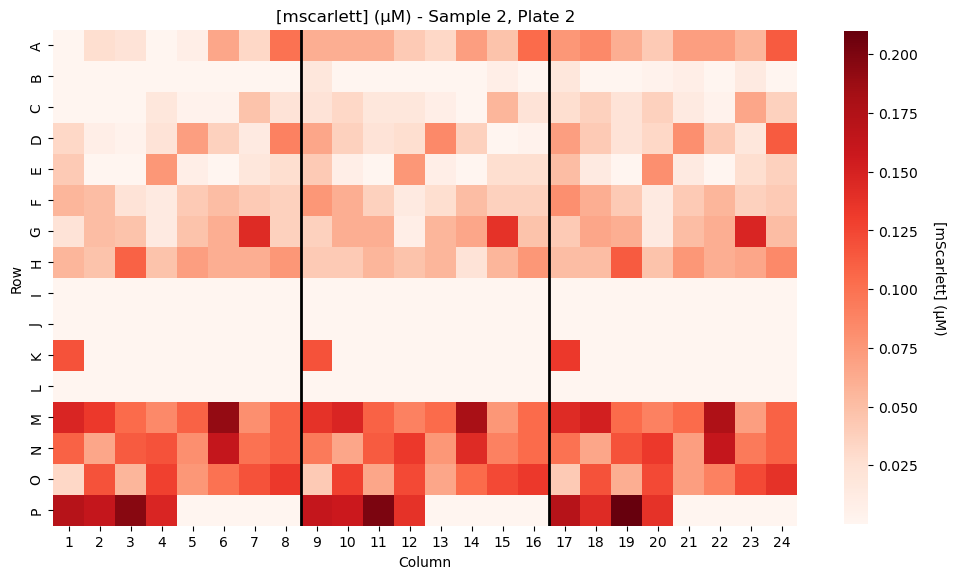

/home/ach94/projects/p13_iterative_optimization/e240_super_r1/neo2_util.py:1295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["Well_Row"] = df_plot["well"].str[0]  # A-P
/home/ach94/projects/p13_iterative_optimization/e240_super_r1/neo2_util.py:1296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["Well_Col"] = df_plot["well"].str[1:].astype(int)  # 1-24


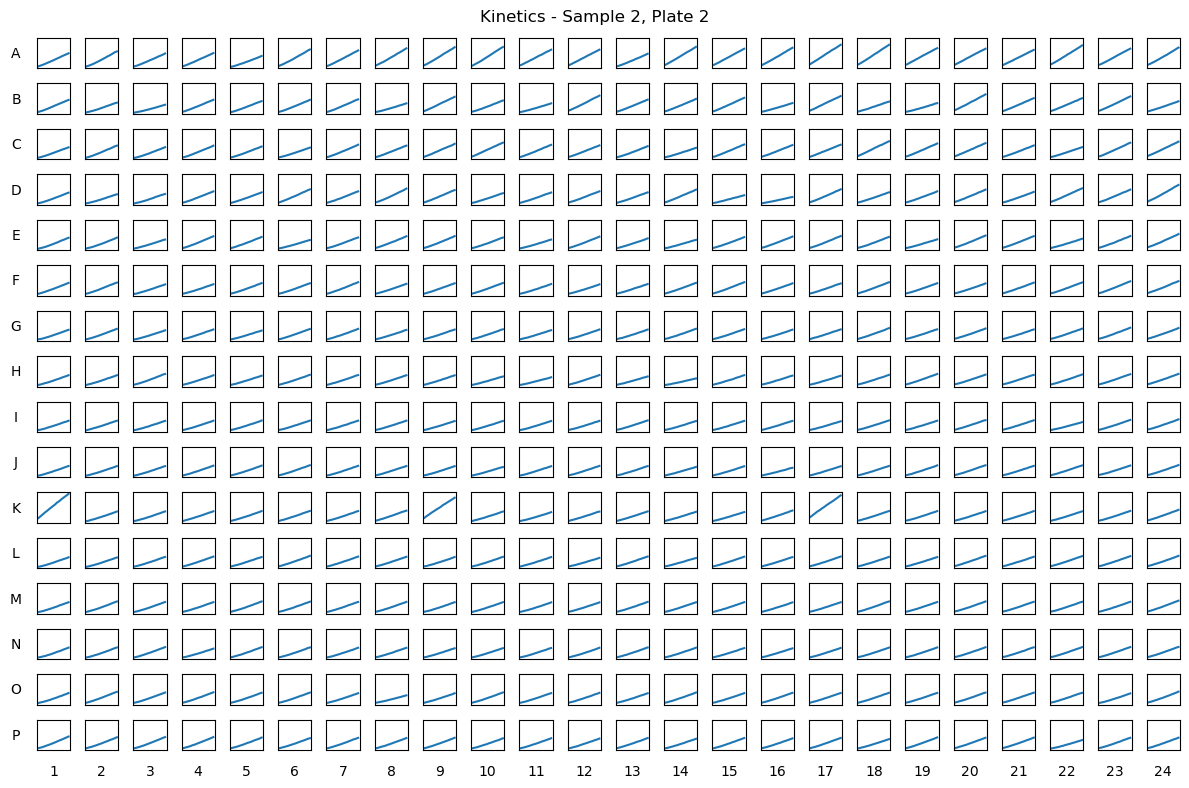

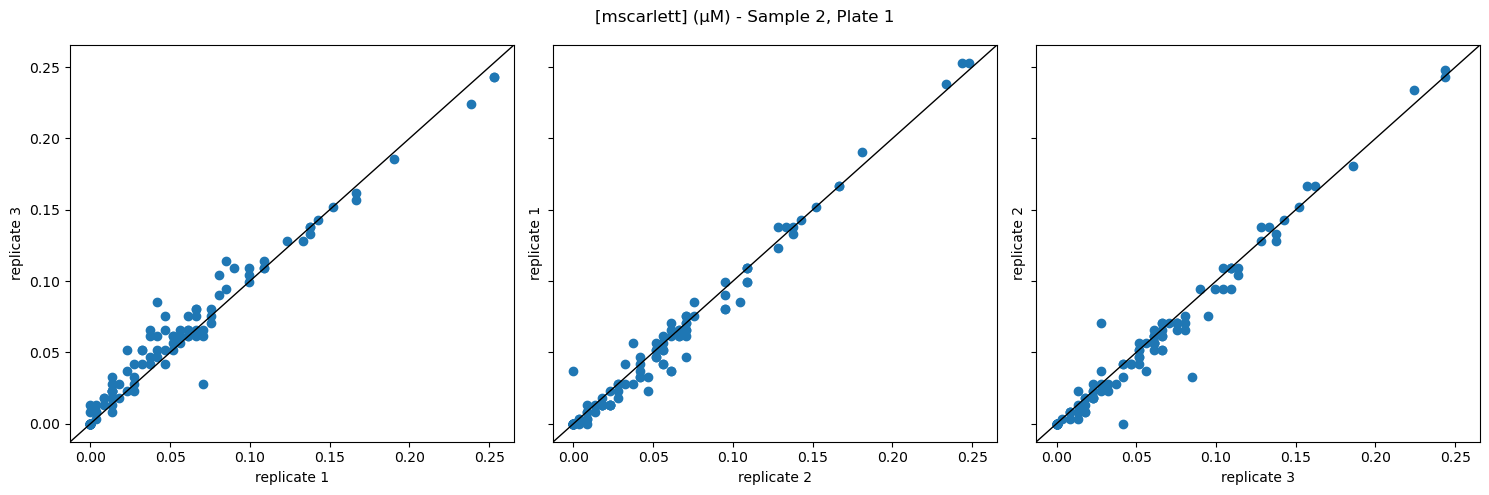

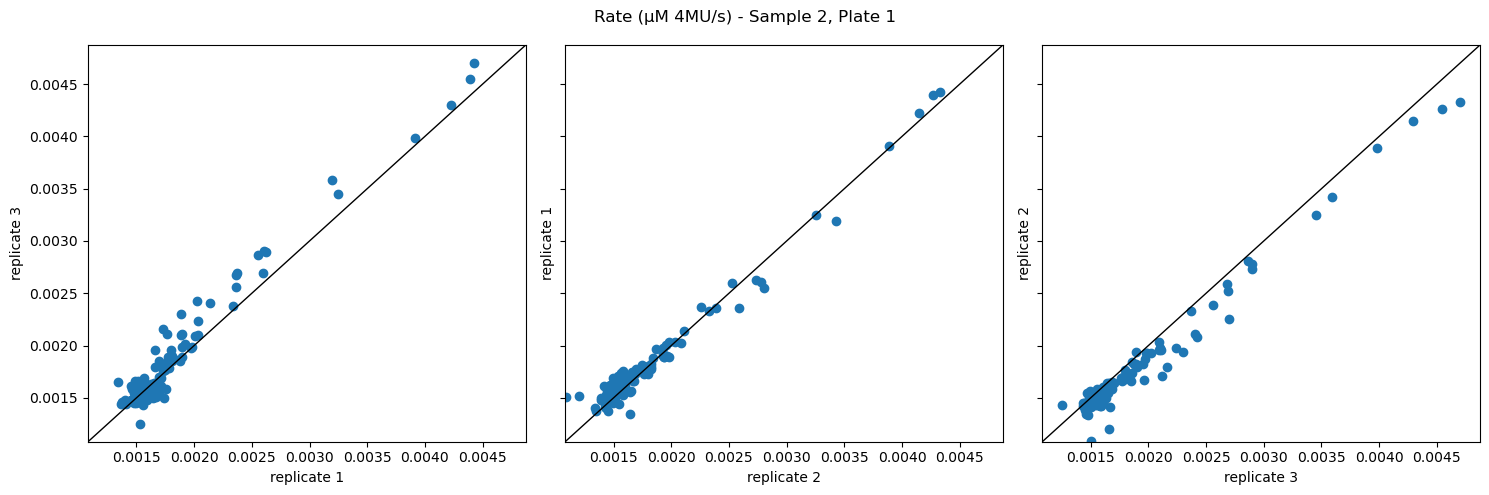

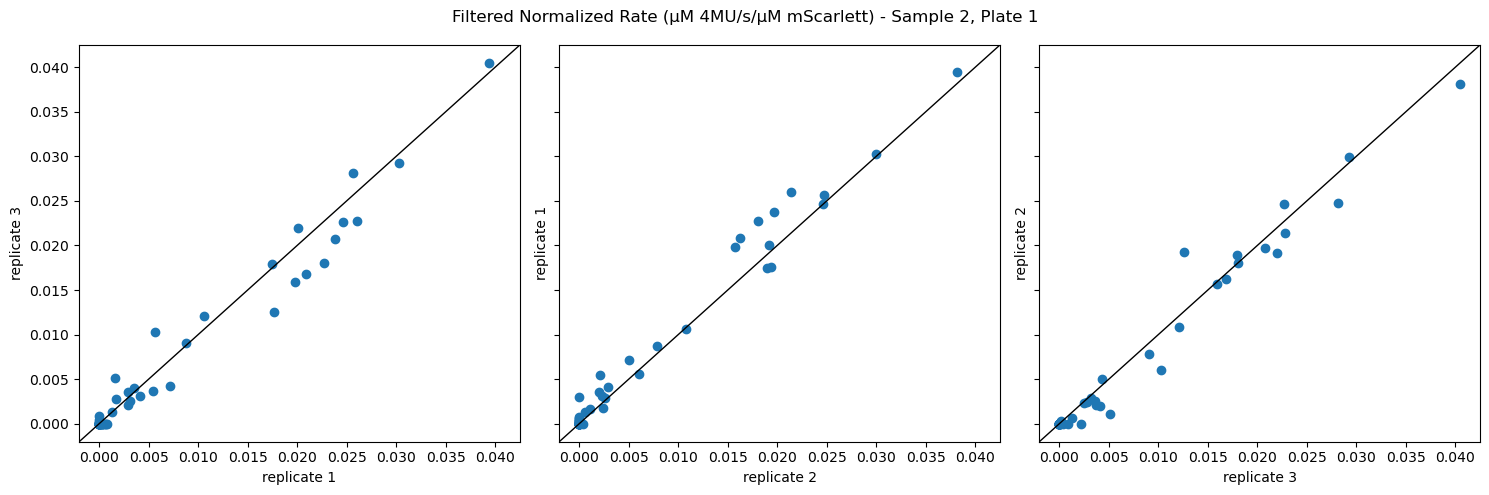

/home/ach94/projects/p13_iterative_optimization/e240_super_r1/neo2_util.py:1228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["row_num"] = df_plot["row"].map(row_map)


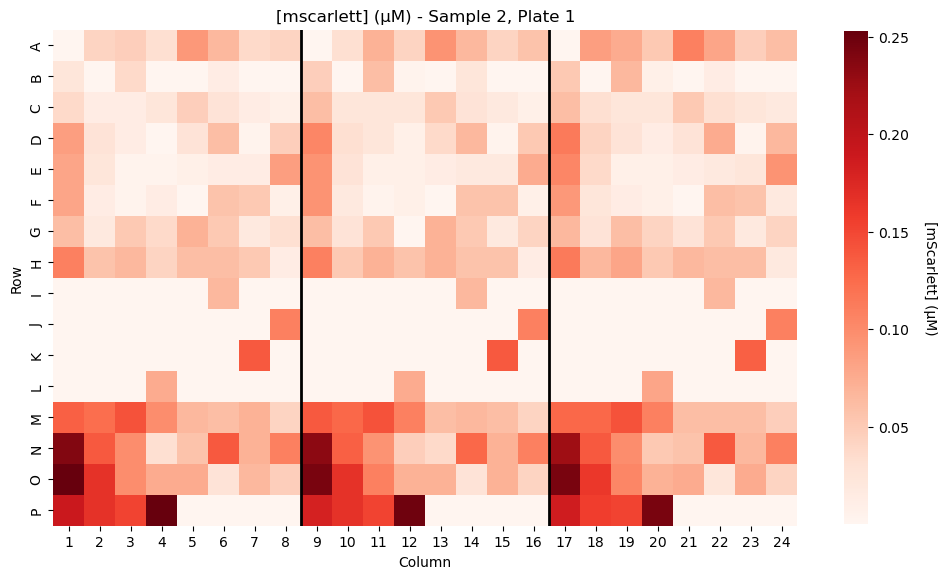

/home/ach94/projects/p13_iterative_optimization/e240_super_r1/neo2_util.py:1295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["Well_Row"] = df_plot["well"].str[0]  # A-P
/home/ach94/projects/p13_iterative_optimization/e240_super_r1/neo2_util.py:1296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["Well_Col"] = df_plot["well"].str[1:].astype(int)  # 1-24


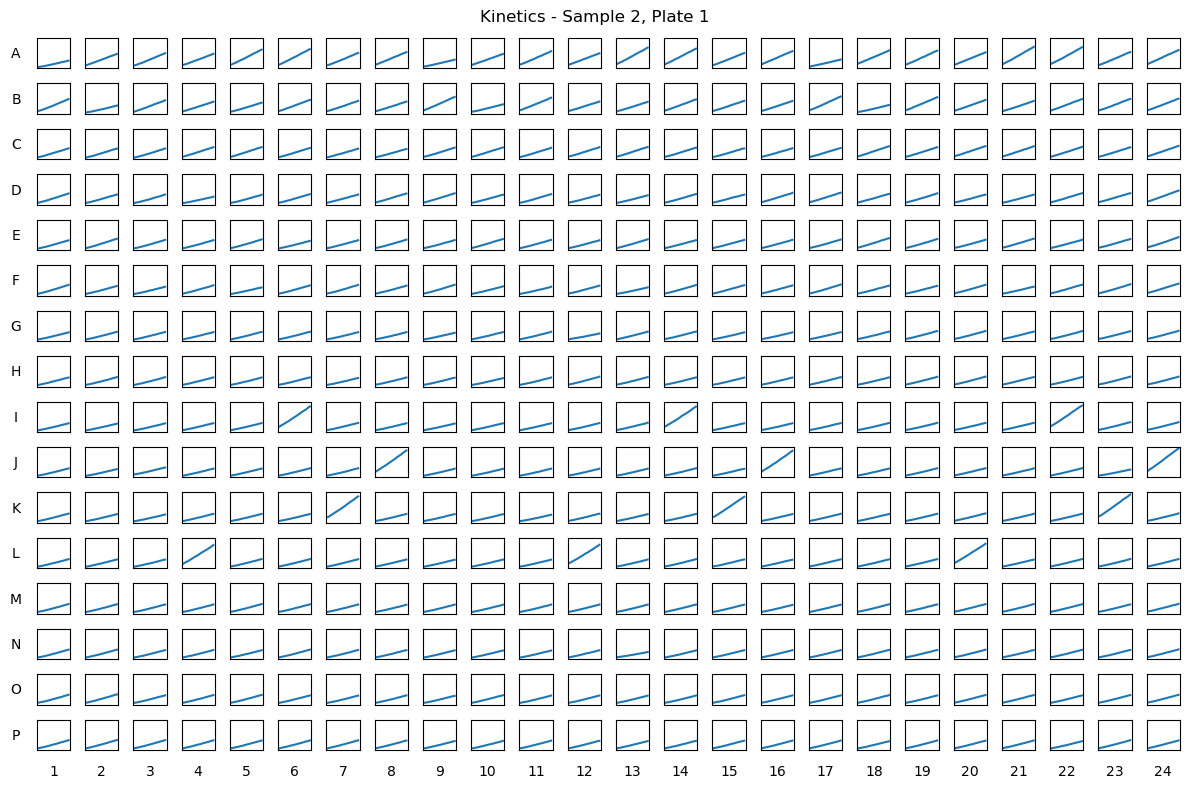

In [91]:
for unique_pair in unique_pairs_list:
    df_plot = df_mscarlett
    value = "mscarlett_um"
    sample_number = unique_pair[0]
    plate_number = unique_pair[1]
    replicates = [1, 2, 3]
    title = f"[mscarlett] (\u03BCM) - Sample {sample_number}, Plate {plate_number}"
    figure_name = f"mcarlett_parity_sample{sample_number}_plate{plate_number}"
    figure_directory = directories["graphs/per_plate"]
    write_figure = True
    write_format = "png"

    fig, axs = parity_plot(
        df_plot,
        value,
        replicates,
        title,
        figure_name,
        figure_directory,
        write_figure,
        write_format,
        sample_number,
        plate_number,
    )

    df_plot = df_kinetics_fits
    value = "rate"
    sample_number = unique_pair[0]
    plate_number = unique_pair[1]
    replicates = [1, 2, 3]
    title = f"Rate (\u03BCM 4MU/s) - Sample {sample_number}, Plate {plate_number}"
    figure_name = f"rate_parity_sample{sample_number}_plate{plate_number}"
    figure_directory = directories["graphs"]
    write_figure = True
    write_format = "png"

    fig, axs = parity_plot(
        df_plot,
        value,
        replicates,
        title,
        figure_name,
        figure_directory,
        write_figure,
        write_format,
        sample_number,
        plate_number,
    )

    # filter for samples where all three replicates pass the mscarlett threshold
    df_plot = df_kinetics_fits
    df_filter = df_stats[df_stats.mscarlett_threshold_pass == True]
    df_plot = df_plot[df_plot["name"].isin(df_filter.name)]
    df_plot = df_plot[df_plot["sample_type"] == "sample"]

    value = "rate_minus_background_normalized"
    sample_number = unique_pair[0]
    plate_number = unique_pair[1]
    replicates = [1, 2, 3]
    title = f"Filtered Normalized Rate (\u03BCM 4MU/s/\u03BCM mScarlett) - Sample {sample_number}, Plate {plate_number}"
    figure_name = f"rate_norm_parity_sample{sample_number}_plate{plate_number}"
    figure_directory = directories["graphs"]
    write_figure = True
    write_format = "png"

    fig, axs = parity_plot(
        df_plot,
        value,
        replicates,
        title,
        figure_name,
        figure_directory,
        write_figure,
        write_format,
        sample_number,
        plate_number,
    )

    df_plot = df_mscarlett
    value = "mscarlett_um"
    sample_number = unique_pair[0]
    plate_number = unique_pair[1]
    title = f"[mscarlett] (\u03BCM) - Sample {sample_number}, Plate {plate_number}"
    figure_name = f"mcarlett_heatmap_sample{sample_number}_plate{plate_number}"
    figure_directory = directories["graphs"]
    write_figure = True
    write_format = "png"

    plot_mscarlett_heatmap(
        df_plot,
        value,
        title,
        figure_name,
        figure_directory,
        sample_number,
        plate_number,
        write_figure,
        write_format,
    )

    df_plot = df_kinetics
    value = "value"
    sample_number = unique_pair[0]
    plate_number = unique_pair[1]
    title = f"Kinetics - Sample {sample_number}, Plate {plate_number}"
    figure_name = f"kinetics_sample{sample_number}_plate{plate_number}"
    figure_directory = directories["graphs"]
    write_figure = True
    write_format = "png"

    plot_384_kinetics(
        df_plot,
        value,
        title,
        figure_name,
        figure_directory,
        write_figure,
        write_format,
        sample_number,
        plate_number,
    )